DNA HotEncoder Difussion adapted from the Annotated diffusion notebook (https://huggingface.co/blog/annotated-diffusion)


Training is taking a lot wihout A100 GPU

-Non bit diffusion implementation  


Contributions   
Lucas Ferreira da Silva  
Luca Pinello  

Tasks

---


 - Transfer task annotation from the diffusion notebook 
 - Reimplement the cell conditional diffusion
 - Fix the architecture to lower the metrics 
 - Is this the best metric (kl motifs absence and presence)?




---
 - remove the comments from OVERFIT to train the model using only one sequence
 - The model is learning since I'm not enforcing the intermediarie steps follow the -1 / + 1 hotencoding constraint. In the last diffusion steps we can notice this convergence (only one 1(+1) and 3 (-1))



# Installs and Downloads

In [1]:
#!pip install einops

In [2]:
# #downloading data
# !wget https://www.dropbox.com/s/db6up7c0d4jwdp4/train_all_classifier_WM20220916.csv.gz?dl=2
# #changing name
# !mv   train_all_classifier_WM20220916.csv.gz?dl=2 train_all_classifier_WM20220916.csv.gz
# #unpcaking
# !gunzip -d /train_all_classifier_WM20220916.csv.gz?dl=2 train_all_classifier_WM20220916.csv
# #new seqs

In [3]:
# !pip install gimmemotifs    #can takes around 10 minutes
# !genomepy install hg38

# Importing

In [1]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
from IPython.display import display
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from tqdm import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
from torch.nn.modules.activation import ReLU
from torch.optim import Adam
from tqdm import tqdm_notebook
from torchvision.utils import save_image
import matplotlib
import math
from inspect import isfunction
from functools import partial
import scipy
from scipy.special import rel_entr
from torch import nn, einsum
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange
from torch import nn, einsum
import torch.nn.functional as F
import matplotlib.animation as animation
import matplotlib.image as mpimg
import glob
from PIL import Image

%matplotlib inline

# Utils

In [2]:
nucleotides = ['A', 'C', 'T', 'G']


def one_hot_encode(seq, alphabet, max_seq_len):
    """One-hot encode a sequence."""
    seq_len = len(seq)
    seq_array = np.zeros((max_seq_len, len(alphabet)))
    for i in range(seq_len):
        seq_array[i, alphabet.index(seq[i])] = 1
    return seq_array


def encode(seq, alphabet):
    """Encode a sequence."""
    seq_len = len(seq)
    seq_array = np.zeros(len(alphabet))
    for i in range(seq_len):
        seq_array[alphabet.index(seq[i])] = 1

    return seq_array


def show_seq(dataloader_seq):
    for i_image in dataloader_seq:
        for image in i_image:
            image = image.numpy().reshape(4, 200)
            print(image)
            plt.rcParams["figure.figsize"] = (20, 1)
            pd_seq = pd.DataFrame(image)
            pd_seq.index = nucleotides
            sns.heatmap(pd_seq, linewidth=1, cmap='bwr', center=0)
            plt.show()


class SequenceDataset(Dataset):
    'Characterizes a dataset for PyTorch'

    def __init__(self, seqs, c, transform=None):
        'Initialization'
        self.seqs = seqs
        self.c = c
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.seqs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        image = self.seqs[index]

        x = self.transform(image)

        y = self.c[index]

        return x, y

## Motif Metric

In [3]:
def sampling_to_metric(number_of_samples=20, specific_group=False):
    # Sampling regions using the trained  model
    final_sequences = []
    for n_a in tqdm_notebook(range(number_of_samples)):  # generating 20*10 sequences
        # sampled_images = bit_diffusion.sample(batch_size = 4)
        sample_bs = 10
        if specific_group:
            sampled = torch.from_numpy(np.array([specific_group] * sample_bs))
        else:
            sampled = torch.from_numpy(np.random.randint(0, len(cell_types), size=(sample_bs)))
        random_classes = torch.zeros((sample_bs, len(cell_types)))
        random_classes = random_classes.scatter_(1, sampled.unsqueeze(dim=1), 1).float().cuda()
        sampled_images = sample(model, classes=random_classes, image_size=image_size, batch_size=sample_bs, channels=1)
        # sampled_images = sampled_images
        for n_b, x in enumerate(sampled_images[-1]):
            # x = x[-1]
            # print(x.shape)
            seq_final = f'>seq_test_{n_a}_{n_b}\n' + ''.join(
                [nucleotides[s] for s in np.argmax(x.reshape(4, 200), axis=0)]
            )
            final_sequences.append(seq_final)

    save_motifs_syn = open('synthetic_motifs.fasta', 'w')

    save_motifs_syn.write('\n'.join(final_sequences))
    save_motifs_syn.close()
    # Scan for motifs
    !gimme scan synthetic_motifs.fasta -p   JASPAR2020_vertebrates -g hg38 > syn_results_motifs.bed
    df_results_syn = pd.read_csv('syn_results_motifs.bed', sep='\t', skiprows=5, header=None)
    df_results_syn['motifs'] = df_results_syn[8].apply(lambda x: x.split('motif_name "')[1].split('"')[0])
    df_results_syn[0] = df_results_syn[0].apply(lambda x: '_'.join(x.split('_')[:-1]))
    df_motifs_count_syn = df_results_syn[[0, 'motifs']].drop_duplicates().groupby('motifs').count()
    plt.rcParams["figure.figsize"] = (30, 2)
    df_motifs_count_syn.sort_values(0, ascending=False).head(50)[0].plot.bar()
    plt.show()

    return df_motifs_count_syn

In [4]:
# Not using the total number of motifs but the count of the occurence aka: percentage of the sequences with a given motif.
def compare_motif_list(df_motifs_a, df_motifs_b):
    # Using KL divergence to compare motifs lists distribution
    set_all_mot = set(df_motifs_a.index.values.tolist() + df_motifs_b.index.values.tolist())
    create_new_matrix = []
    for x in set_all_mot:
        list_in = []
        list_in.append(x)  # adding the name
        if x in df_motifs_a.index:
            list_in.append(df_motifs_a.loc[x][0])
        else:
            list_in.append(1)

        if x in df_motifs_b.index:
            list_in.append(df_motifs_b.loc[x][0])
        else:
            list_in.append(1)

        create_new_matrix.append(list_in)

    df_motifs = pd.DataFrame(create_new_matrix, columns=['motif', 'motif_a', 'motif_b'])

    df_motifs['Diffusion_seqs'] = df_motifs['motif_a'] / df_motifs['motif_a'].sum()
    df_motifs['Training_seqs'] = df_motifs['motif_b'] / df_motifs['motif_b'].sum()
    plt.rcParams["figure.figsize"] = (3, 3)
    sns.regplot(x='Diffusion_seqs', y='Training_seqs', data=df_motifs)
    plt.xlabel('Diffusion Seqs')
    plt.ylabel('Training Seqs')
    plt.title('Motifs Probs')
    plt.show()

    display(df_motifs)
    kl_pq = rel_entr(df_motifs['Diffusion_seqs'].values, df_motifs['Training_seqs'].values)
    return np.sum(kl_pq)


# compare_motif_list(synt_df, df_results_seq_guime_count)

Alternative Metric

---
  - Are our synthetic regulatory regions predicted as enhancers in a orthogonal model?  
  - Can we predict it? (This is a metric similar to the critical actor on a GAN but not forcing it during training or inference time  (we could!)) 
  - This paper is using gans to do the same thing than us and using a classifier to guide the creation (https://www.biorxiv.org/content/10.1101/2022.07.26.501466v1.full.pdf)
   - DeepFlyBrain? what are they using? (sequeces-> cell type --> base contribution-> use negative score to represent important mutations (repressive motifs))
   

```
Background model
To	 compare	 against	 the	 GAN-generated	 sequences,	 we	
generated	 random	 sequences	in	 different	 orders	 by	 using	
the	 CreateBackgroundModel function	 from	 the	 INCLUSive	
package	62 based	on	the	same	genomic	regions	that	we	used	
to	train	GANs.
```




 - https://github.com/khanhlee/bert-enhancer
 - https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-017-1878-3#Ack1

<img src='https://raw.githubusercontent.com/pinellolab/DNA-Diffusion/dna-diffusion/other_files/Predicting%20enhancers%20with%20deep%20convolutional%20neural%20networks%20_%20BMC%20Bioinformatics%20_%20Full%20Text.png'>

<img src='https://github.com/khanhlee/bert-enhancer/raw/main/figures/flowchart.png'>



# Diffusion

In [5]:
# FUNCTION CHANGED ADD CONDITIONING
@torch.no_grad()
def p_sample(model, x, classes, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    # print (x.shape, 'x_shape')
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, classes=classes, time=t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise


# Algorithm 2 but save all images:

# FUNCTION CHANGED ADD CONDITIONING


@torch.no_grad()
def p_sample_loop(model, classes, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, x=img, classes=classes, t=torch.full((b,), i, device=device, dtype=torch.long), t_index=i)
        imgs.append(img.cpu().numpy())
    return imgs


# FUNCTION CHANGED ADD CONDITIONING


@torch.no_grad()
def sample(model, classes, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, classes=classes, shape=(batch_size, channels, 4, image_size))

### schedule

In [6]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)


def linear_beta_schedule(timesteps, beta_end=0.005):
    beta_start = 0.0001

    return torch.linspace(beta_start, beta_end, timesteps)


def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2


def sigmoid_beta_schedule(timesteps):
    beta_start = 0.001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

### Foward diffusion


In [7]:
# forward diffusion
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)

    # print  (sqrt_alphas_cumprod_t , sqrt_one_minus_alphas_cumprod_t , t)

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

### Loss

In [8]:
# FUNCTION CHANGED ADD CONDITIONING


def p_losses(denoise_model, x_start, t, classes, noise=None, loss_type="l1"):  #
    if noise is None:
        noise = torch.randn_like(x_start)  #  guass noise
    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)  # this is the auto generated noise given t and Noise
    # print('max_q_sample', x_noisy.max(), 'mean_q_sample',x_noisy.mean() )
    predicted_noise = denoise_model(x_noisy, t, classes)  # this is the predicted noise given the model and step t
    # print('max_predicted', x_noisy.max(), 'mean_predicted',x_noisy.mean() )

    # #predicted is ok (clipped)
    # print ('predited inside loss')
    # print (predicted_noise)
    # print ('this is the noise generated by the p_losses')
    # print (noise)
    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        # print (noise.shape, 'noise' )
        # print (predicted_noise.shape, 'pred')
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

# Models

### Simple CNND2

In [9]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class ResBlock(nn.Module):

    """
    Iniialize a residual block with two convolutions followed by batchnorm layers
    """

    def __init__(self, in_size: int, hidden_size: int, out_size: int):
        super().__init__()
        self.conv1 = nn.Conv2d(in_size, hidden_size, 3, padding=1)
        self.conv2 = nn.Conv2d(hidden_size, out_size, 3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(hidden_size)
        self.batchnorm2 = nn.BatchNorm2d(out_size)

    def convblock(self, x):
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = F.relu(self.batchnorm2(self.conv2(x)))
        return x

    """
    Combine output with the original input
    """

    def forward(self, x):
        return x + self.convblock(x)  # skip connection


class ConvBlock_2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, padding=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 4, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # print ('x', x.shape)
        x = self.conv1(x)
        # print ('conv1', x.shape)
        x = self.conv2(x)
        # print ('conv2', x.shape)
        # x = F.avg_pool2d(x, 2)

        return x


class Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.res = nn.Sequential(ResBlock(1, 2, 1), ResBlock(1, 2, 1), ResBlock(1, 2, 1), ResBlock(1, 2, 1))

        self.conv = nn.Sequential(
            ConvBlock_2d(in_channels=1, out_channels=2),
            nn.ReLU(),
            nn.BatchNorm2d(2),
            ConvBlock_2d(in_channels=2, out_channels=4),
            nn.ReLU(),
            nn.BatchNorm2d(4),
            ConvBlock_2d(in_channels=4, out_channels=1),
            nn.BatchNorm2d(1)
            # ConvBlock_2d(in_channels=1, out_channels=1),
            # ConvBlock_2d(in_channels=1, out_channels=1),
            # ConvBlock_2d(in_channels=1, out_channels=1),
        )

        self.fc = nn.Sequential(
            nn.Linear(800, 800),
            # nn.GELU(),
            nn.BatchNorm1d(800),  # ALWAYS BATCHNORM THIS CHANGES A LOT THE RESULTS
            # nn.Linear(400, 400),
            # nn.BatchNorm1d(400),
            # nn.GELU(),
            # nn.BatchNorm1d(400),
        )

        self.fc2 = nn.Sequential(
            nn.Linear(400, 800),
            # nn.GELU(),
            nn.BatchNorm1d(800),  # ALWAYS BATCHNORM THIS CHANGES A LOT THE RESULTS
            # nn.Linear(400, 400),
            # nn.GELU(),
            # nn.BatchNorm1d(400),
        )

        time_dim = 200 * 4
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(100),
            nn.Linear(100, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )

        self.time_mlp_out = nn.Sequential(
            SinusoidalPositionEmbeddings(100),
            nn.Linear(100, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )

    def forward(self, x, y):
        # print (x.shape, 'inside model x ')
        x_a = x.clone()
        # y_a = y.clone()
        x = self.res(x)

        # print ('to_full', x.shape)

        y_emb = self.time_mlp(y)
        # y_emb_out = self.time_mlp_out(y_a)

        x = x.view(-1, 800)

        x_a = x.view(-1, 800)
        x_a = self.fc(x_a)

        x = x + y_emb.view(-1, 800) * x_a

        # x = self.fc2(x)
        # x = x + y_emb_out.view(-1,400) + x_a

        # x = torch.clip(x, min=-1, max=1)
        x = x.view(-1, 1, 4, 200)

        # x = x.view(-1,1,200,4)

        # print (x.shape)
        # The cliping is working already checked
        return x

### UNET and UTILS

In [10]:
# THIS is a new function  to accomodate the conditional


class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embedding things  
        '''
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [11]:
def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d


def cycle(dl):
    while True:
        for data in dl:
            yield data


def has_int_squareroot(num):
    return (math.sqrt(num) ** 2) == num


def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr


def convert_image_to(img_type, image):
    if image.mode != img_type:
        return image.convert(img_type)
    return image


def l2norm(t):
    return F.normalize(t, dim=-1)


# small helper modules


def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


def Upsample(dim, dim_out=None):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode='nearest'), nn.Conv2d(dim, default(dim_out, dim), 3, padding=1)
    )


def Downsample(dim, dim_out=None):
    return nn.Conv2d(dim, default(dim_out, dim), 4, 2, 1)


class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3
        var = torch.var(x, dim=1, unbiased=False, keepdim=True)
        mean = torch.mean(x, dim=1, keepdim=True)
        return (x - mean) * (var + eps).rsqrt() * self.g


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)


# positional embeds


class LearnedSinusoidalPosEmb(nn.Module):
    """following @crowsonkb 's lead with learned sinusoidal pos emb"""

    """ https://github.com/crowsonkb/v-diffusion-jax/blob/master/diffusion/models/danbooru_128.py#L8 """

    def __init__(self, dim):
        super().__init__()
        assert (dim % 2) == 0
        half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(half_dim))

    def forward(self, x):
        x = rearrange(x, 'b -> b 1')
        freqs = x * rearrange(self.weights, 'd -> 1 d') * 2 * math.pi
        fouriered = torch.cat((freqs.sin(), freqs.cos()), dim=-1)
        fouriered = torch.cat((x, fouriered), dim=-1)
        return fouriered


# building block modules


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x


class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out * 2)) if exists(time_emb_dim) else None

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b c 1 1')
            scale_shift = time_emb.chunk(2, dim=1)

        h = self.block1(x, scale_shift=scale_shift)

        h = self.block2(h)

        return h + self.res_conv(x)


# FUNCTION CHANGED ADD CONDITIONING


class ResnetBlockClassConditioned(ResnetBlock):
    def __init__(self, dim, dim_out, *, num_classes, class_embed_dim, time_emb_dim=None, groups=8):
        super().__init__(dim=dim + class_embed_dim, dim_out=dim_out, time_emb_dim=time_emb_dim, groups=groups)
        self.class_mlp = EmbedFC(num_classes, class_embed_dim)

    def forward(self, x, time_emb=None, c=None, mask=None):
        emb_c = self.class_mlp(c)
        emb_c = emb_c.view(*emb_c.shape, 1, 1)
        emb_c = emb_c.expand(-1, -1, x.shape[-2], x.shape[-1])

        if mask:
            # mask classes so we can jointly train condtioned and unconditioned
            # masking with 1e-9 like we do in Transformers
            emb_c = emb_c.masked_fill(mask, 1e-9)

        x = torch.cat([x, emb_c], axis=1)

        return super().forward(x, time_emb)


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), LayerNorm(dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h=self.heads), qkv)

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        v = v / (h * w)

        context = torch.einsum('b h d n, b h e n -> b h d e', k, v)

        out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b (h c) x y', h=self.heads, x=h, y=w)
        return self.to_out(out)


class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32, scale=10):
        super().__init__()
        self.scale = scale
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h=self.heads), qkv)

        q, k = map(l2norm, (q, k))

        sim = einsum('b h d i, b h d j -> b h i j', q, k) * self.scale
        attn = sim.softmax(dim=-1)
        out = einsum('b h i j, b h d j -> b h i d', attn, v)
        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x=h, y=w)
        return self.to_out(out)


# model

# bit diffusion class


def log(t, eps=1e-20):
    return torch.log(t.clamp(min=eps))


def right_pad_dims_to(x, t):
    padding_dims = x.ndim - t.ndim
    if padding_dims <= 0:
        return t
    return t.view(*t.shape, *((1,) * padding_dims))


def beta_linear_log_snr(t):
    return -torch.log(expm1(1e-4 + 10 * (t**2)))


def alpha_cosine_log_snr(t, s: float = 0.008):
    return -log(
        (torch.cos((t + s) / (1 + s) * math.pi * 0.5) ** -2) - 1, eps=1e-5
    )  # not sure if this accounts for beta being clipped to 0.999 in discrete version


def log_snr_to_alpha_sigma(log_snr):
    return torch.sqrt(torch.sigmoid(log_snr)), torch.sqrt(torch.sigmoid(-log_snr))


# ClASS CHANGED ADD CONDITIONING


class Unet_lucas(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        dim_mults=(1, 2, 4),
        channels=1,
        resnet_block_groups=8,
        learned_sinusoidal_dim=16,
        num_classes=10,
        class_embed_dim=3,
    ):
        super().__init__()

        # determine dimensions

        channels = 1
        self.channels = channels

        input_channels = channels * 2
        # print ('input channels',input_channels)

        init_dim = default(init_dim, dim)
        print(init_dim, 'init_dim')
        # self.init_conv = nn.Conv2d(input_channels, init_dim, 7, padding = 3) # original
        self.init_conv = nn.Conv2d(input_channels, init_dim, (7, 7), padding=3)

        # print (self.init_conv)
        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        # print (dims)

        in_out = list(zip(dims[:-1], dims[1:]))
        # print (in_out)
        block_klass = partial(
            ResnetBlockClassConditioned,
            groups=resnet_block_groups,
            num_classes=num_classes,
            class_embed_dim=class_embed_dim,
        )

        # time embeddings

        time_dim = dim * 4

        sinu_pos_emb = LearnedSinusoidalPosEmb(learned_sinusoidal_dim)
        fourier_dim = learned_sinusoidal_dim + 1

        self.time_mlp = nn.Sequential(
            sinu_pos_emb, nn.Linear(fourier_dim, time_dim), nn.GELU(), nn.Linear(time_dim, time_dim)
        )

        # layers

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Downsample(dim_in, dim_out) if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding=1),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Upsample(dim_out, dim_in) if not is_last else nn.Conv2d(dim_out, dim_in, 3, padding=1),
                    ]
                )
            )

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim=time_dim)
        # self.final_res_block = block_klass(1, dim, time_emb_dim = time_dim)

        # self.final_conv = nn.Conv2d(dim, channels, 1)
        self.final_conv = nn.Conv2d(dim, 1, 1)
        # print('self.final_conv' , self.final_conv)

        print('final', dim, channels, self.final_conv)

    def forward(self, x, time, classes, x_self_cond=None):
        # print (x.shape ,'in_shape')
        x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
        x = torch.cat((x_self_cond, x), dim=1)

        x = self.init_conv(x)
        # print ('init_conv', x.shape)
        r = x.clone()

        t = self.time_mlp(time)
        if classes is None:
            classes = torch.zeros((x.shape[0], self.num_classes))
            context_mask = torch.ones((x.shape[0]))

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t, classes)
            h.append(x)

            x = block2(x, t, classes)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t, classes)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t, classes)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t, classes)

            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t, classes)
            x = attn(x)

            x = upsample(x)

        # print('x torch_after_upsamples',x.shape)

        x = torch.cat((x, r), dim=1)
        # print('x tochcat', x.shape)

        x = self.final_res_block(x, t, classes)
        # print(self.final_res_block)
        # print('x from res_block before final_conv',x.shape)
        # print (self.final_conv(x).shape)
        x = self.final_conv(x)
        # print ('FINAL X', x.shape)
        return x

# Loading data and generating fasta files and motifs

In [37]:
# Loading Dataset
df = pd.read_csv("train_all_classifier_WM20220916.csv", sep="\t")
df.head()
df = df.sample(8000)  # Using 4000k cells

Text(0.5, 1.0, 'Component % on Training Sample')

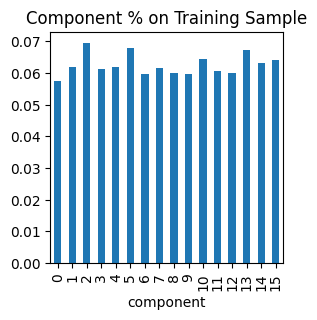

In [38]:
(df.groupby('component').count()['raw_sequence'] / df.groupby('component').count()['raw_sequence'].sum()).plot.bar()
plt.title('Component % on Training Sample')

In [39]:
df

Unnamed: 0 seqname      start        end  DHS_width     summit  \
91915      2045472   chr22   33834860   33835120        260   33835090   
10522      1562796   chr19   50292300   50292500        200   50292410   
53116      1461349   chr18   54202940   54203160        220   54203030   
151098     3278098    chr8  119764480  119764716        236  119764590   
103268      701239   chr12   27780320   27780740        420   27780550   
...            ...     ...        ...        ...        ...        ...   
62262      2236153    chr3  131961740  131962100        360  131961950   
126297      324216   chr10    8349480    8349860        380    8349700   
10197      1451084   chr18   46445580   46445780        200   46445690   
133309      745202   chr12   64664420   64664620        200   64664510   
73541      2664501    chr5  132026760  132026969        209  132026880   

        total_signal  numsamples  numpeaks        C1  ...       C10       C11  \
91915       0.506276           1         1  0.000000  ...  0.000000  0.000000   
10522      10.969485          11        11  0.000000  ...  0.000000  0.000000   
53116       1.777531           3         3  0.000000  ...  0.000046  0.000000   
151098      2.430332           4         4  0.000000  ...  0.000000  0.000000   
103268      0.760209           1         1  0.000561  ...  0.000000  0.000000   
...              ...         ...       ...       ...  ...       ...       ...   
62262       3.170421           4         4  0.000000  ...  0.000000  0.000000   
126297      2.754060           2         2  0.000000  ...  0.000000  0.000000   
10197       6.398176          11        11  0.000000  ...  0.026391  0.006446   
133309      0.781073           1         1  0.000000  ...  0.000000  0.000000   
73541      46.871654          20        20  0.000000  ...  0.000000  0.000000   

        C12       C13       C14       C15       C16  \
91915   0.0  0.000000  0.000000  0.000000  0.000000   
10522   0.0  0.000000  0.000000  0.000000  0.000000   
53116   0.0  0.000000  0.000000  0.000000  0.020306   
151098  0.0  0.000000  0.000000  0.000000  0.000000   
103268  0.0  0.004483  0.000000  0.000000  0.000000   
...     ...       ...       ...       ...       ...   
62262   0.0  0.000000  0.000000  0.000000  0.000000   
126297  0.0  0.000000  0.000000  0.000000  0.000000   
10197   0.0  0.000000  0.000000  0.000000  0.000000   
133309  0.0  0.000000  0.000532  0.000189  0.003501   
73541   0.0  0.000000  0.000000  0.000000  0.000000   

                                             raw_sequence  component  \
91915   AATATGCCTCAGCGACAAAGCTACAGCTTTAGAAATGATACAGTTA...          7   
10522   GCACCTCCCGGGAGGAGATCTTCTCCCAGAATCGGGAAAGTGAAAA...          2   
53116   TTCCCAGAGATGGAGACAATGAAGCTGGGTCTTGGATGAGTAGGAG...         15   
151098  AAGCATAATGGCATGCTGTAAAGTAACATGGTAATACTAAAAACAT...          4   
103268  GCCCTGAGCCAGGAGGCCGGCGGCCCGGAGGTGCAGCAGCTGCGCG...         12   
...                                                   ...        ...   
62262   TTATCTCTCTCCCTTCTCCCTTTTCCCTACTCAGATCCAGATCTGC...          6   
126297  CACGTCTGGAAACCCAAGAATTTGGCATTTACCTTCTAGATGGGTG...          4   
10197   ACAACTTTCAGAGACCTCAGCCTCCTGGAAATAAGATCTCTGAATC...          5   
133309  TATTCTGTGCAGTTTACACCTGCATAGGCCACCCATCTCGGCCTCC...         15   
73541   CTGGGGGCGGTGGGGCTGCTGTACACATTTCCTGGCACACGCTTCC...          4   

        proportion  
91915     1.000000  
10522     1.000000  
53116     0.997722  
151098    1.000000  
103268    0.888776  
...            ...  
62262     1.000000  
126297    1.000000  
10197     0.699225  
133309    0.723773  
73541     0.997665  

[8000 rows x 28 columns]

In [40]:
def generate_heatmap_motifs(df_results_seq_matrix):
    print('Generating Matrix....')
    all_motifs = {m_init: 0 for m_init in set(df_results_seq_matrix['motifs'].values)}
    sequen_dic = {seq_init: all_motifs.copy() for seq_init in set(df_results_seq_matrix[0].values)}

    for k, v in df_results_seq_matrix.groupby([0, 'motifs']):
        sequen_dic[k[0]][k[1]] = v.count()[0]

    df_motifs_matrix = pd.DataFrame(sequen_dic).T
    df_motifs_matrix['comps'] = [int(comp_i.split('_')[-1]) for comp_i in df_motifs_matrix.index.values]
    df_motifs_matrix = df_motifs_matrix.sort_values(['comps'])
    comp_rows = df_motifs_matrix['comps'].values
    del df_motifs_matrix['comps']
    df_motifs_matrix

    pal_hls = sns.hls_palette(16).as_hex()
    {e: c for e, c in enumerate(pal_hls[:])}
    sns.clustermap(
        df_motifs_matrix, cmap='Reds', row_cluster=True, row_colors=[pal_hls[c_extract] for c_extract in comp_rows]
    )
    plt.show()

In [41]:
def motifs_from_fasta(fasta, generate_heatmap=True):
    print('Computing Motifs....')
    !gimme scan $fasta -p  JASPAR2020_vertebrates -g hg38 > train_results_motifs.bed
    df_results_seq_guime = pd.read_csv('train_results_motifs.bed', sep='\t', skiprows=5, header=None)
    df_results_seq_guime['motifs'] = df_results_seq_guime[8].apply(lambda x: x.split('motif_name "')[1].split('"')[0])
    if generate_heatmap:
        generate_heatmap_motifs(df_results_seq_guime)

    df_results_seq_guime[0] = df_results_seq_guime[0].apply(lambda x: '_'.join(x.split('_')[:-1]))
    df_results_seq_guime_count_out = df_results_seq_guime[[0, 'motifs']].drop_duplicates().groupby('motifs').count()
    plt.rcParams["figure.figsize"] = (30, 2)
    df_results_seq_guime_count_out.sort_values(0, ascending=False).head(50)[0].plot.bar()
    plt.title('Top 50 MOTIFS on component 0 ')
    plt.show()
    return df_results_seq_guime_count_out


# df_results_seq_guime_count wil be used to compute the motifs distances

In [42]:
# Save the Fasta to compute the motifs in the training sequences


# new function
def save_fasta(df):
    save_fasta = open('fastq_train_component.fasta', 'w')
    write_fasta_component = '\n'.join(
        df[['Unnamed: 0', 'raw_sequence', 'component']]
        .apply(lambda x: f'>{x[0]}_component_{x[2]}\n{x[1]}', axis=1)
        .values.tolist()
    )
    save_fasta.write(write_fasta_component)
    save_fasta.close()

In [43]:
df.head()

Unnamed: 0 seqname      start        end  DHS_width     summit  \
91915      2045472   chr22   33834860   33835120        260   33835090   
10522      1562796   chr19   50292300   50292500        200   50292410   
53116      1461349   chr18   54202940   54203160        220   54203030   
151098     3278098    chr8  119764480  119764716        236  119764590   
103268      701239   chr12   27780320   27780740        420   27780550   

        total_signal  numsamples  numpeaks        C1  ...       C10  C11  C12  \
91915       0.506276           1         1  0.000000  ...  0.000000  0.0  0.0   
10522      10.969485          11        11  0.000000  ...  0.000000  0.0  0.0   
53116       1.777531           3         3  0.000000  ...  0.000046  0.0  0.0   
151098      2.430332           4         4  0.000000  ...  0.000000  0.0  0.0   
103268      0.760209           1         1  0.000561  ...  0.000000  0.0  0.0   

             C13  C14  C15       C16  \
91915   0.000000  0.0  0.0  0.000000   
10522   0.000000  0.0  0.0  0.000000   
53116   0.000000  0.0  0.0  0.020306   
151098  0.000000  0.0  0.0  0.000000   
103268  0.004483  0.0  0.0  0.000000   

                                             raw_sequence  component  \
91915   AATATGCCTCAGCGACAAAGCTACAGCTTTAGAAATGATACAGTTA...          7   
10522   GCACCTCCCGGGAGGAGATCTTCTCCCAGAATCGGGAAAGTGAAAA...          2   
53116   TTCCCAGAGATGGAGACAATGAAGCTGGGTCTTGGATGAGTAGGAG...         15   
151098  AAGCATAATGGCATGCTGTAAAGTAACATGGTAATACTAAAAACAT...          4   
103268  GCCCTGAGCCAGGAGGCCGGCGGCCCGGAGGTGCAGCAGCTGCGCG...         12   

        proportion  
91915     1.000000  
10522     1.000000  
53116     0.997722  
151098    1.000000  
103268    0.888776  

[5 rows x 28 columns]

Computing Motifs....
scanning: 100%|████████████████████| 8000/8000 [00:16<00:00, 489.99 sequences/s]
Generating Matrix....


/srv/local/fast_anaconda/envs/dna-diffusion/lib/python3.10/site-packages/seaborn/matrix.py:657: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


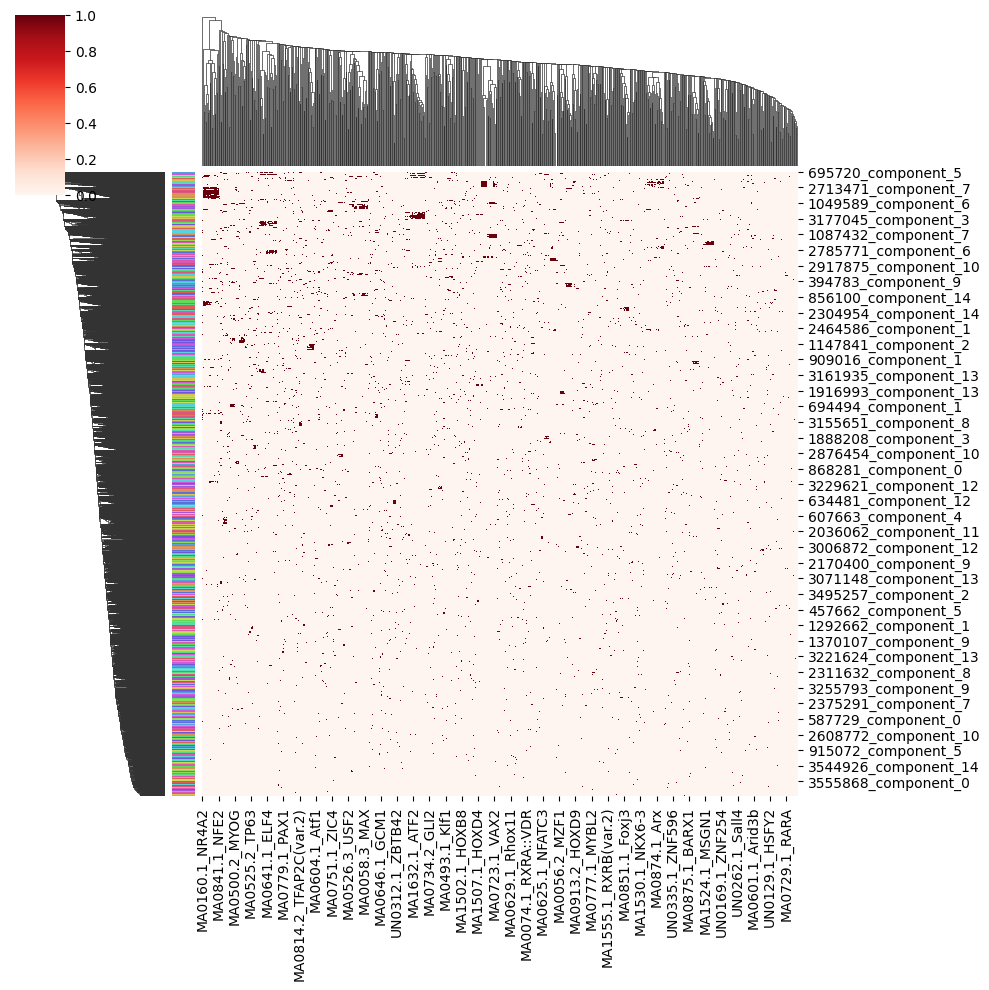

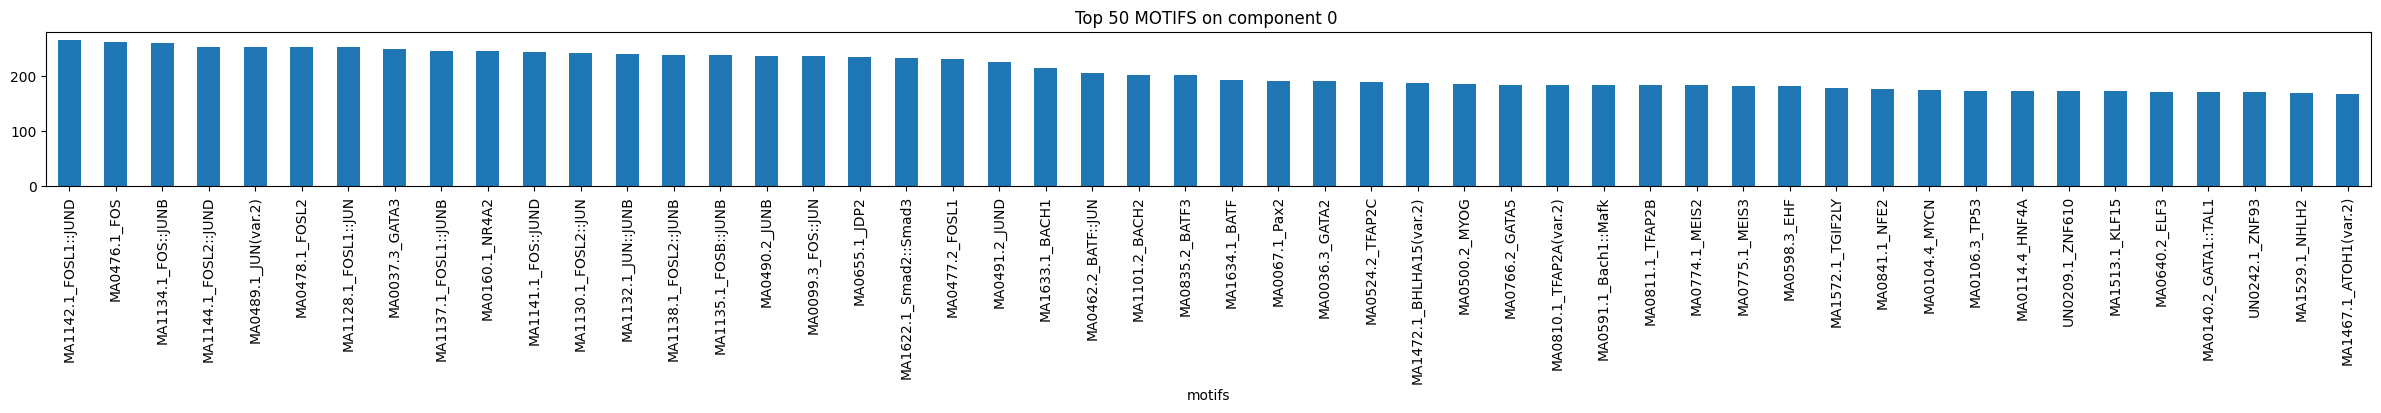

In [44]:
# changed
save_fasta(df)
df_results_seq_guime_count = motifs_from_fasta('fastq_train_component.fasta')

### Generate motifs for each component

0
Computing Motifs....
scanning: 100%|███████████████████████| 459/459 [00:07<00:00, 57.39 sequences/s]


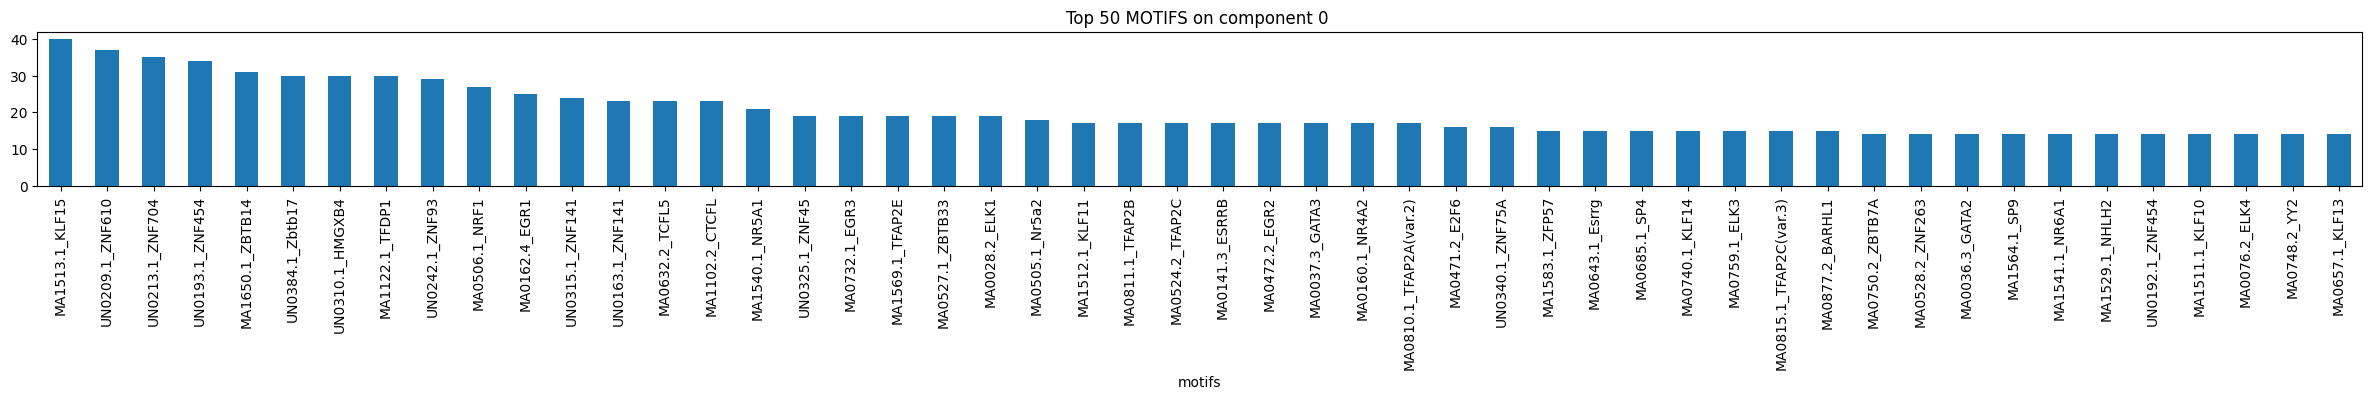

1
Computing Motifs....
scanning: 100%|███████████████████████| 495/495 [00:08<00:00, 59.94 sequences/s]


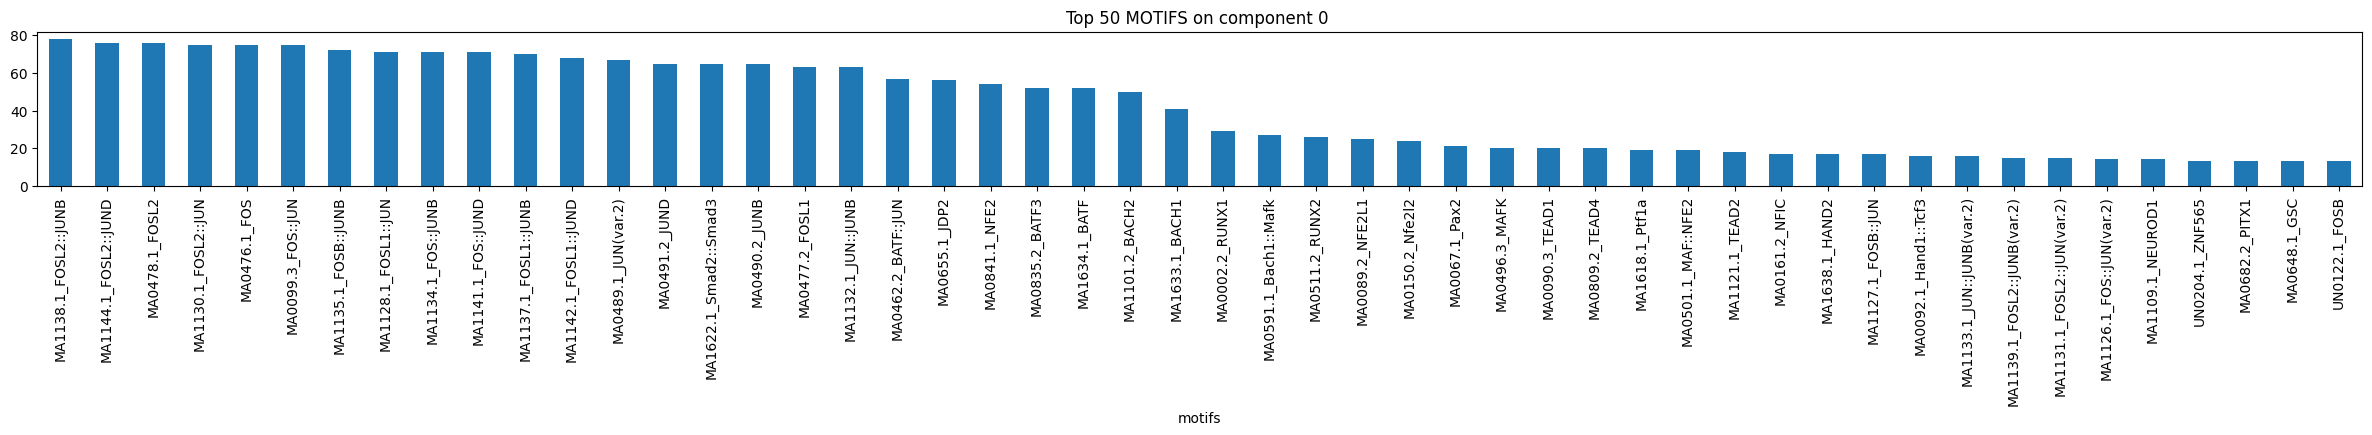

2
Computing Motifs....
scanning: 100%|███████████████████████| 556/556 [00:08<00:00, 62.99 sequences/s]


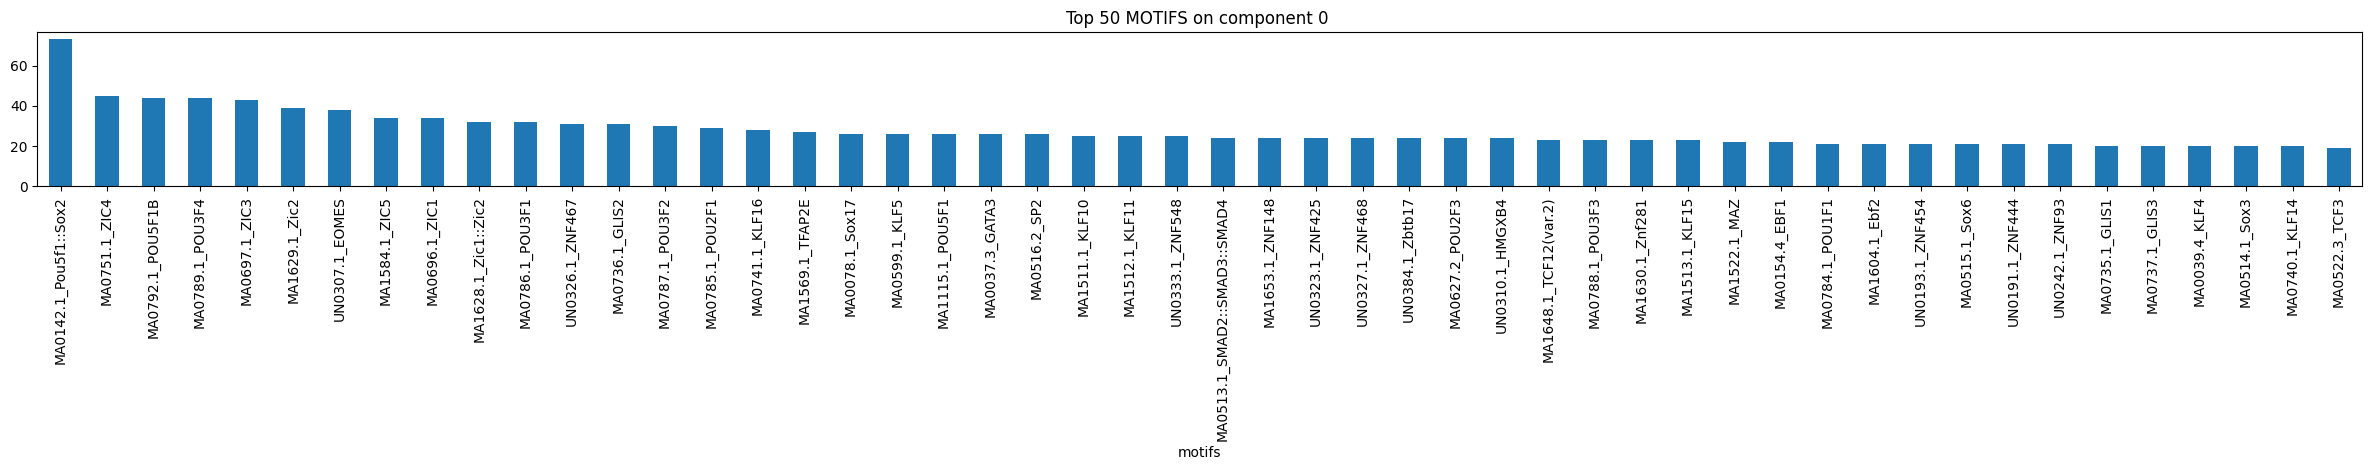

3
Computing Motifs....
scanning: 100%|███████████████████████| 491/491 [00:07<00:00, 61.71 sequences/s]


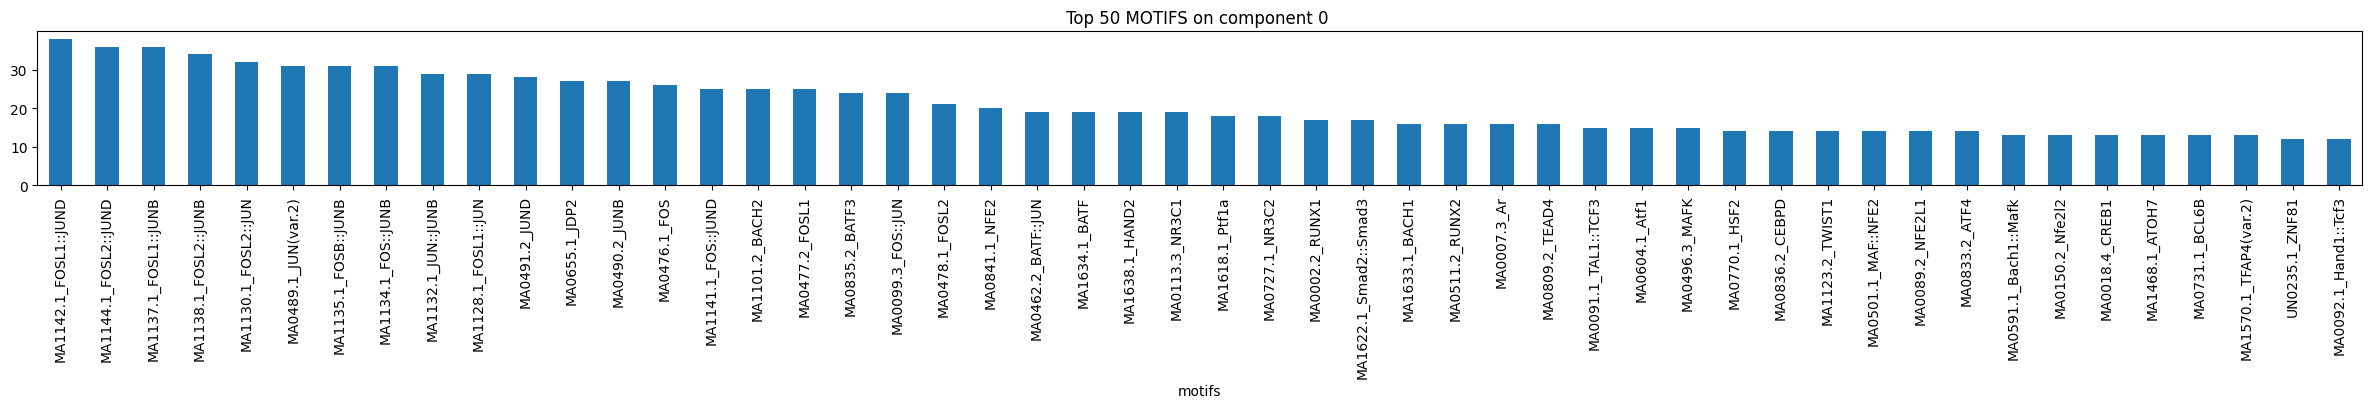

4
Computing Motifs....
scanning: 100%|███████████████████████| 495/495 [00:07<00:00, 62.29 sequences/s]


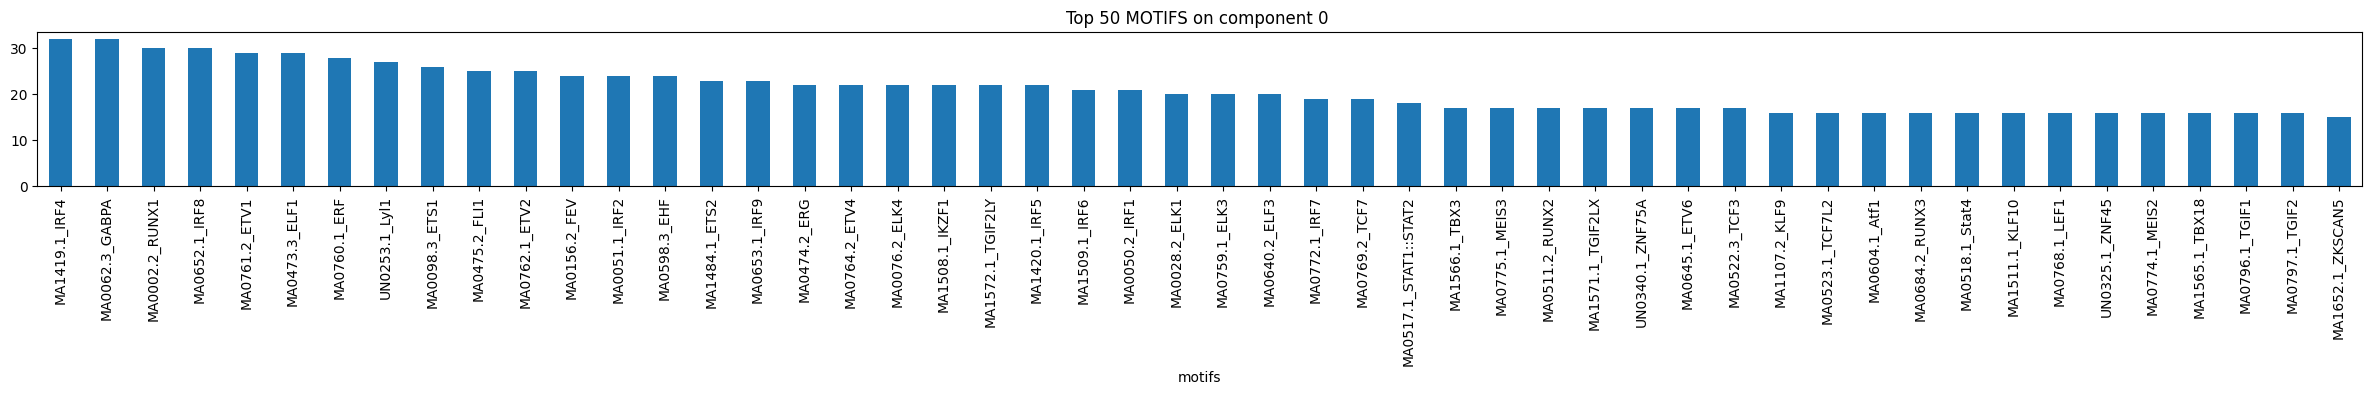

5
Computing Motifs....
scanning: 100%|███████████████████████| 543/543 [00:08<00:00, 64.89 sequences/s]


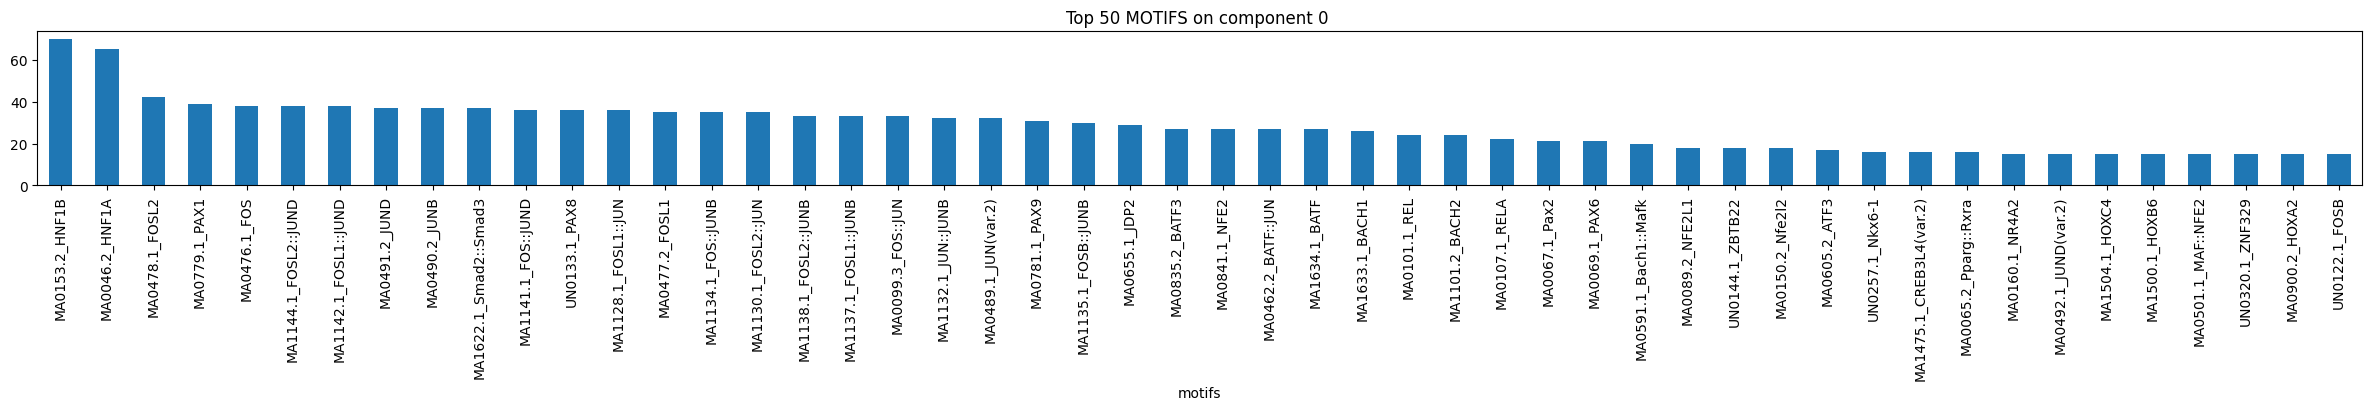

6
Computing Motifs....
scanning: 100%|███████████████████████| 478/478 [00:07<00:00, 61.46 sequences/s]


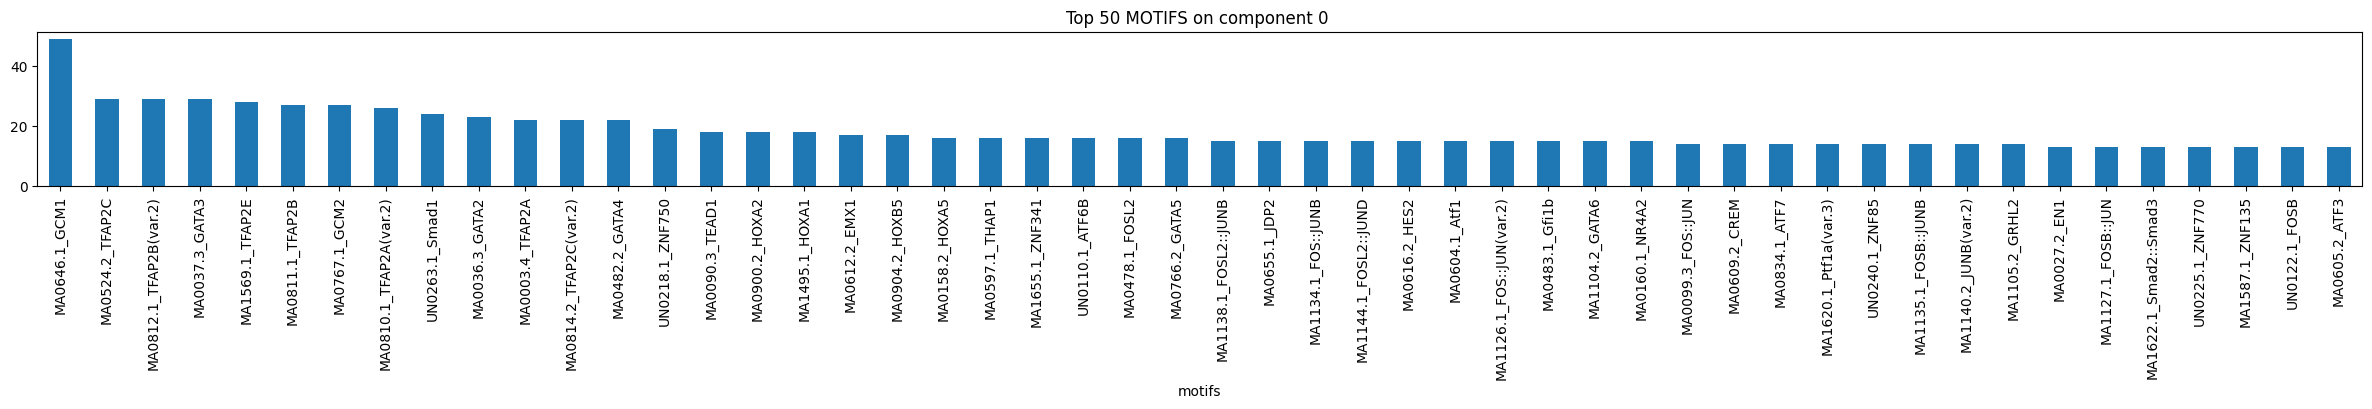

7
Computing Motifs....
scanning: 100%|███████████████████████| 494/494 [00:08<00:00, 60.51 sequences/s]


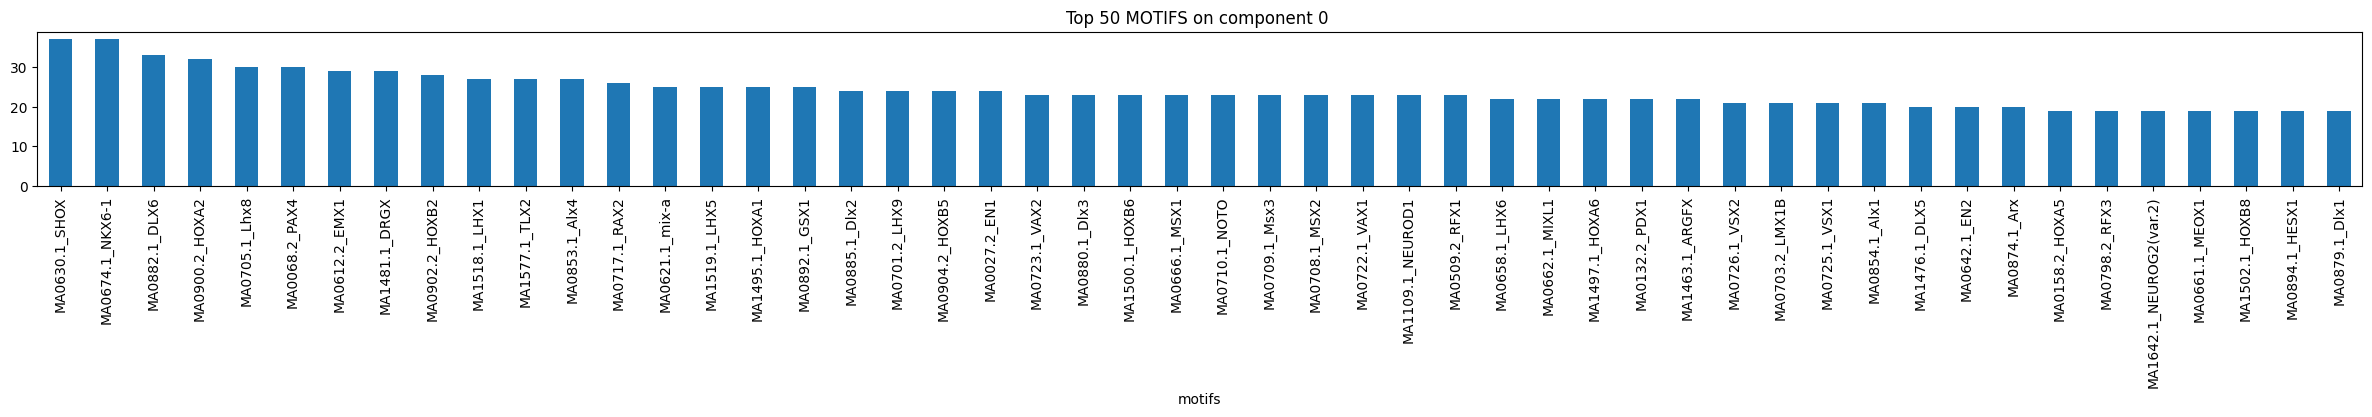

8
Computing Motifs....
scanning: 100%|███████████████████████| 479/479 [00:07<00:00, 61.92 sequences/s]


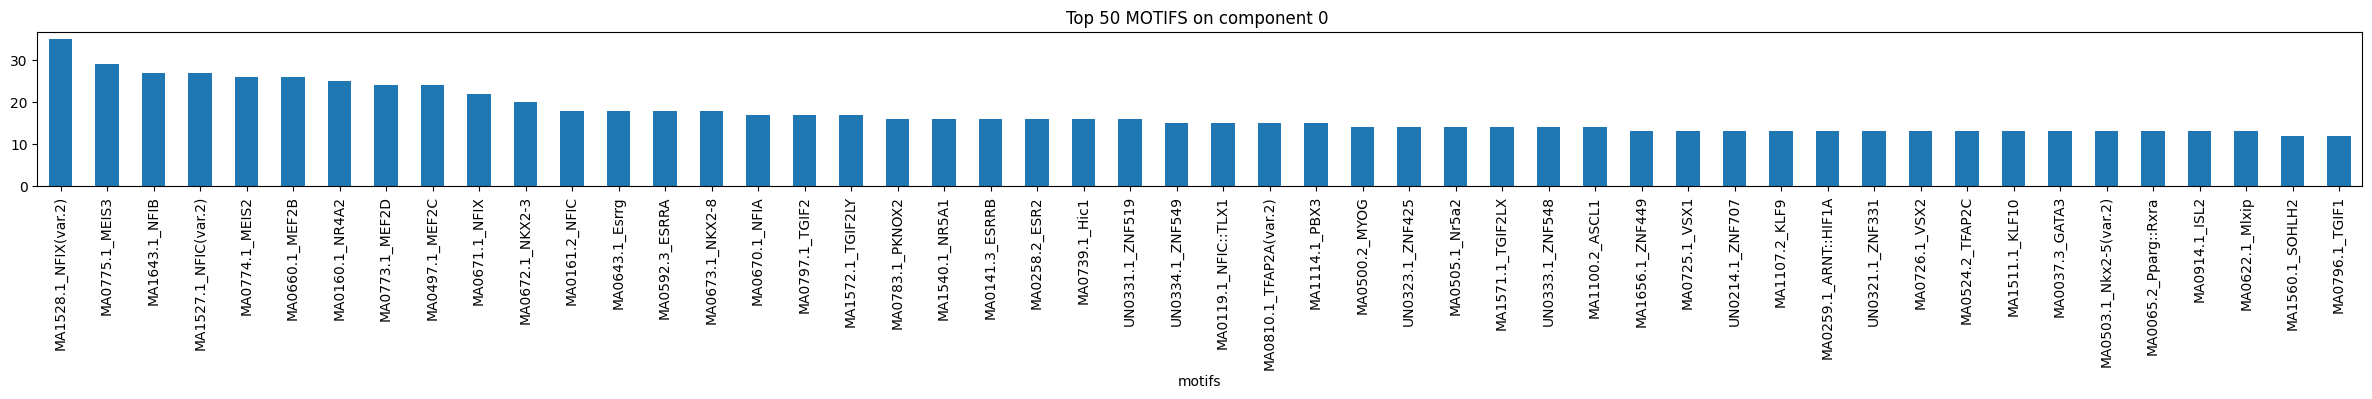

9
Computing Motifs....
scanning: 100%|███████████████████████| 477/477 [00:07<00:00, 61.77 sequences/s]


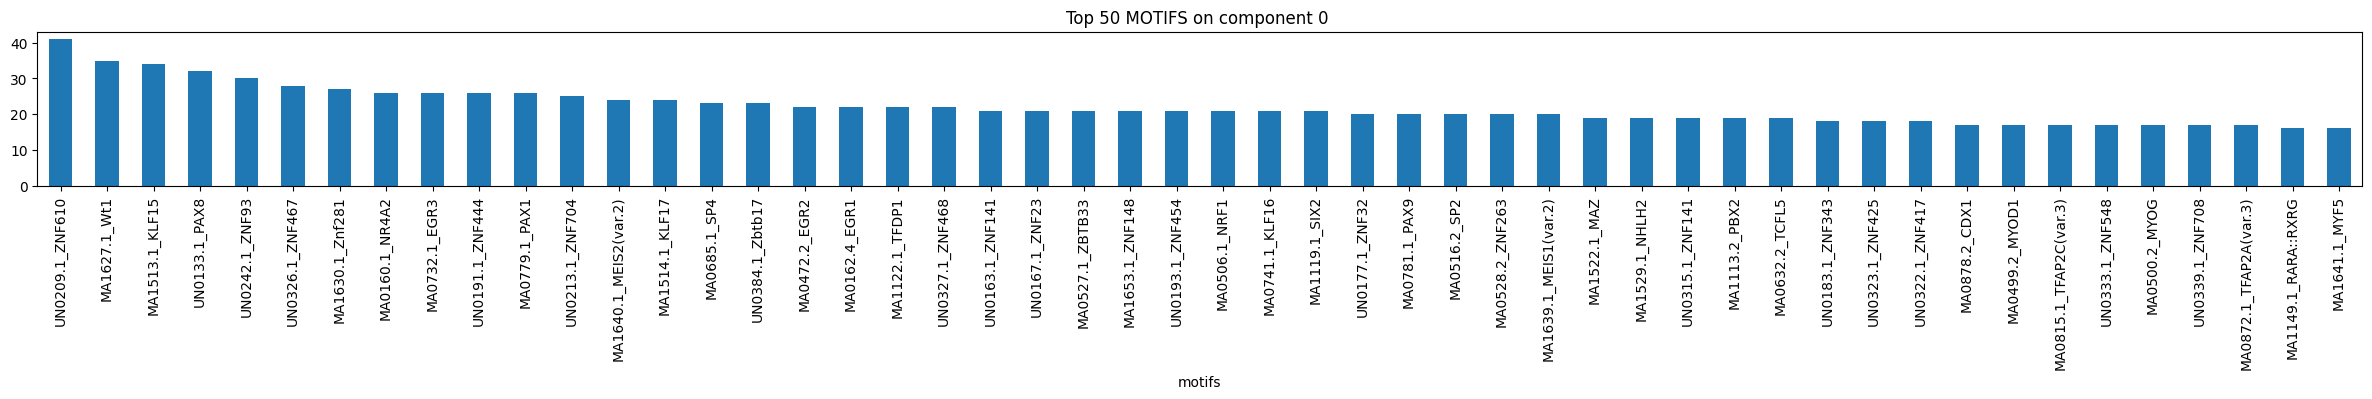

10
Computing Motifs....
scanning: 100%|███████████████████████| 515/515 [00:08<00:00, 62.73 sequences/s]


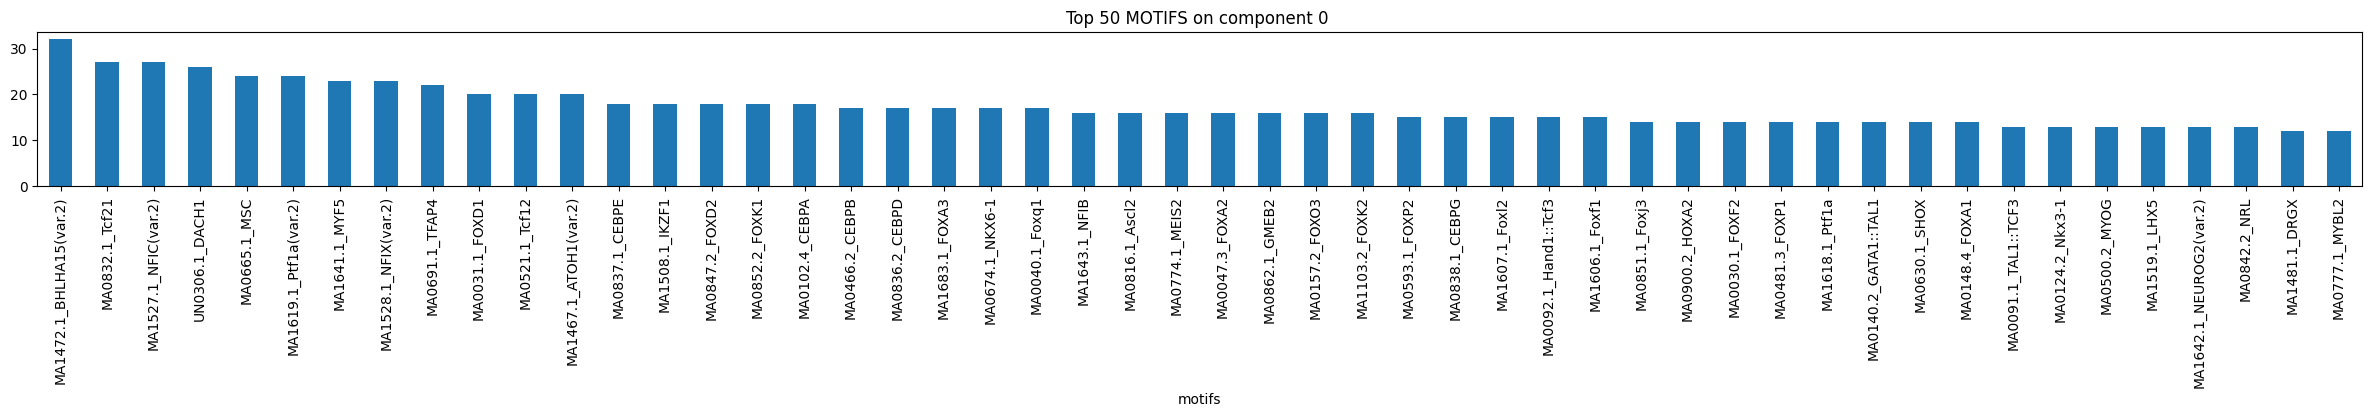

11
Computing Motifs....
scanning: 100%|███████████████████████| 484/484 [00:08<00:00, 58.11 sequences/s]


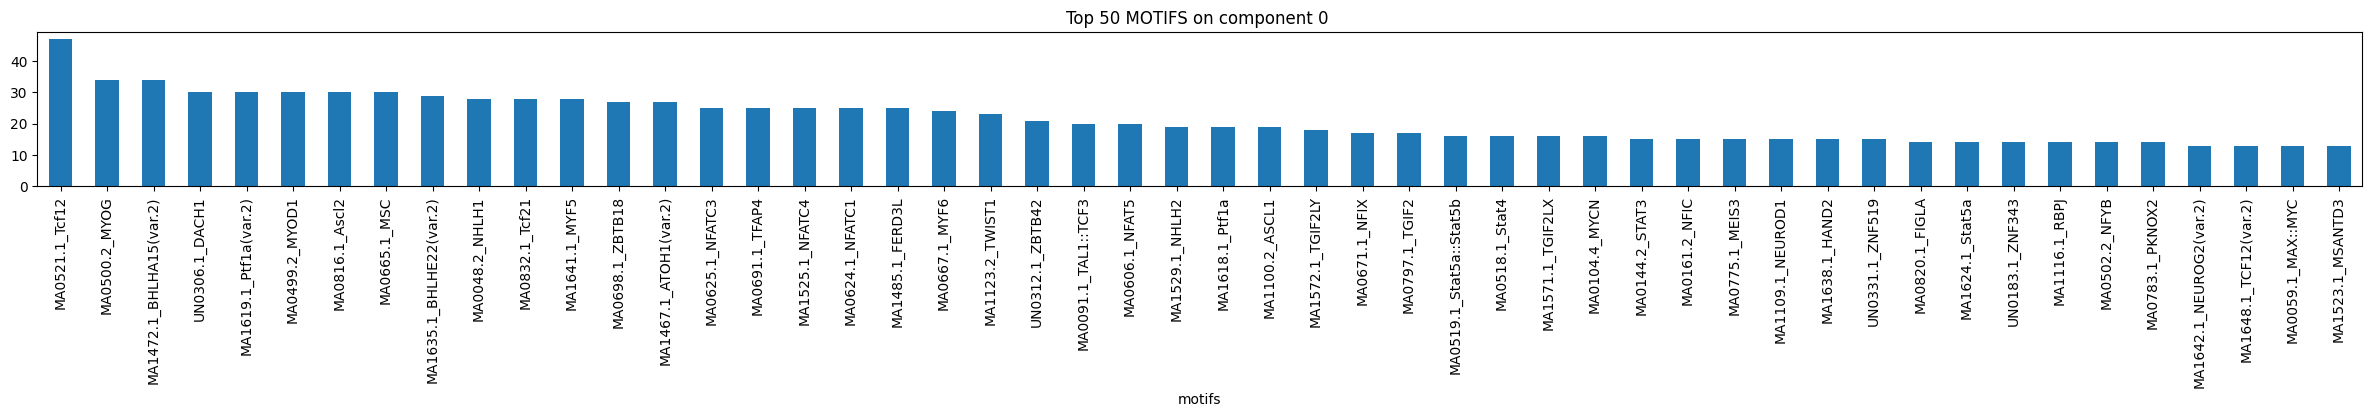

12
Computing Motifs....
scanning: 100%|███████████████████████| 479/479 [00:07<00:00, 61.09 sequences/s]


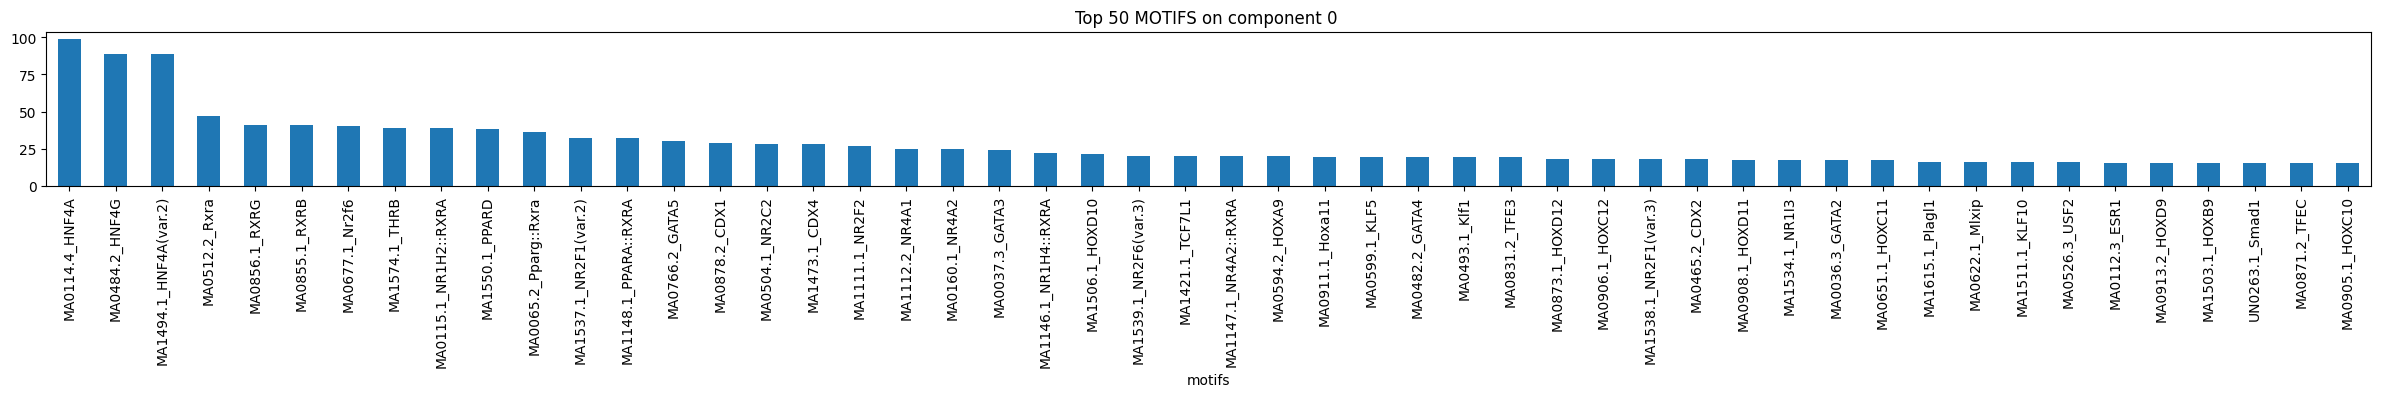

13
Computing Motifs....
scanning: 100%|███████████████████████| 537/537 [00:08<00:00, 63.92 sequences/s]


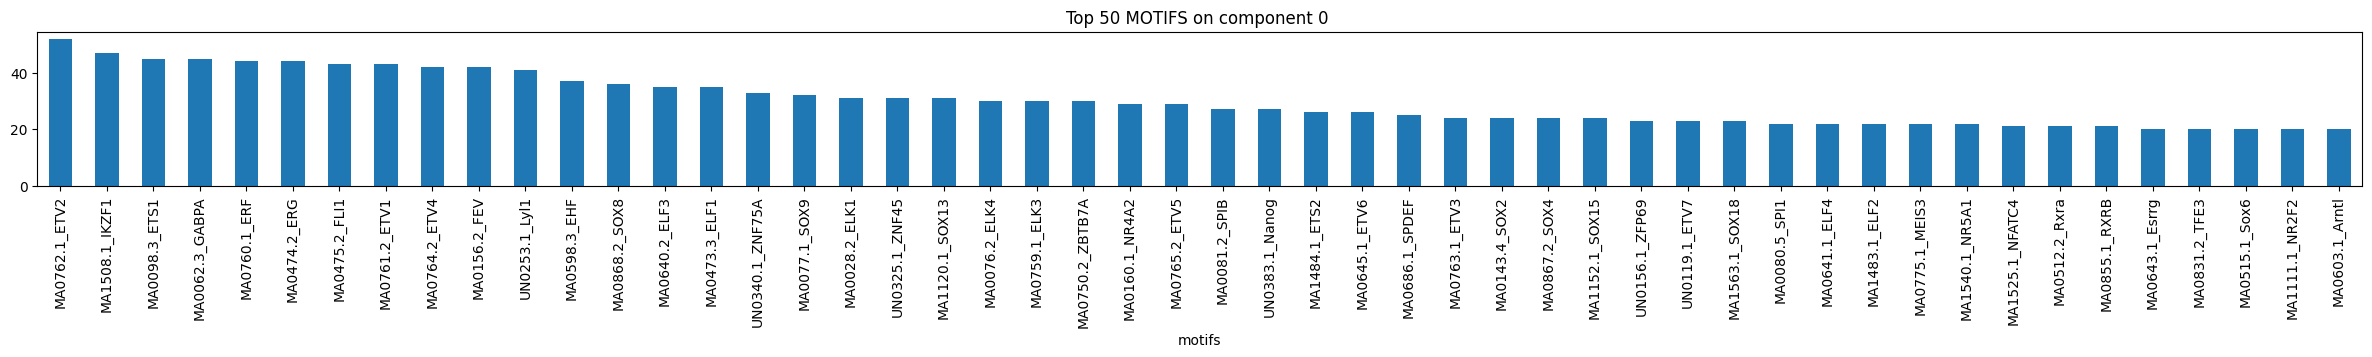

14
Computing Motifs....
scanning: 100%|███████████████████████| 505/505 [00:08<00:00, 58.20 sequences/s]


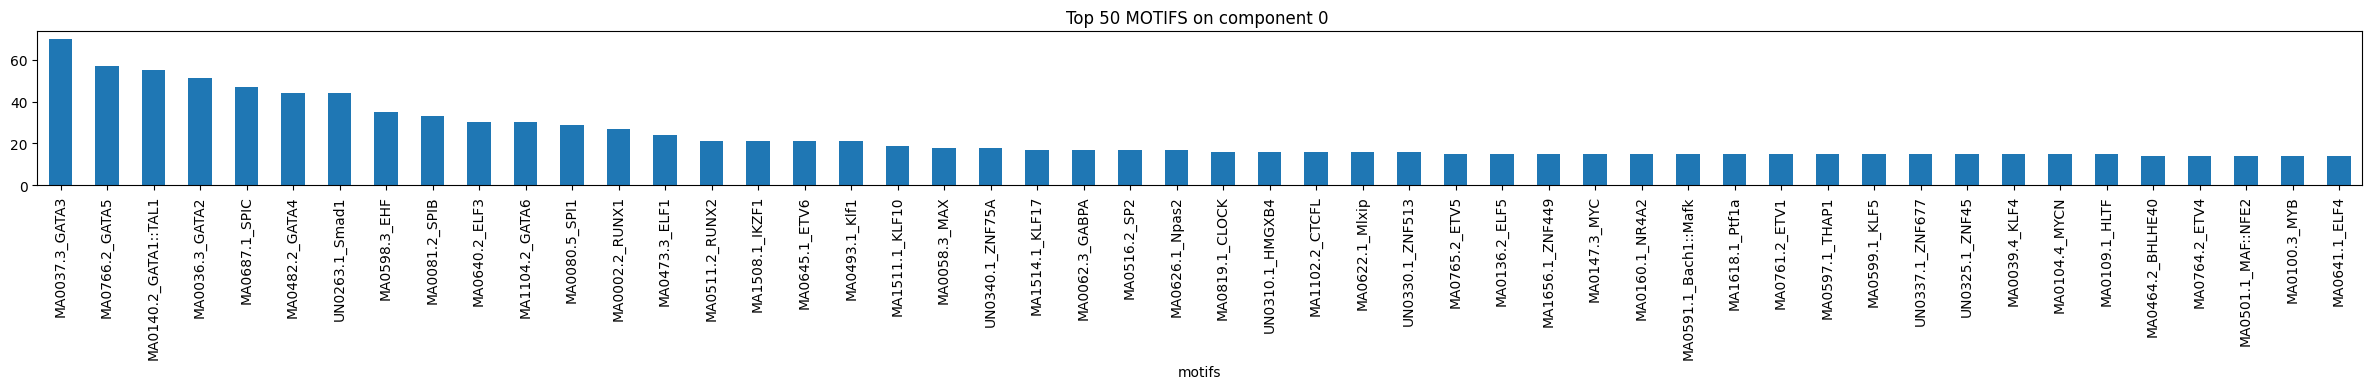

15
Computing Motifs....
scanning: 100%|███████████████████████| 513/513 [00:08<00:00, 62.05 sequences/s]


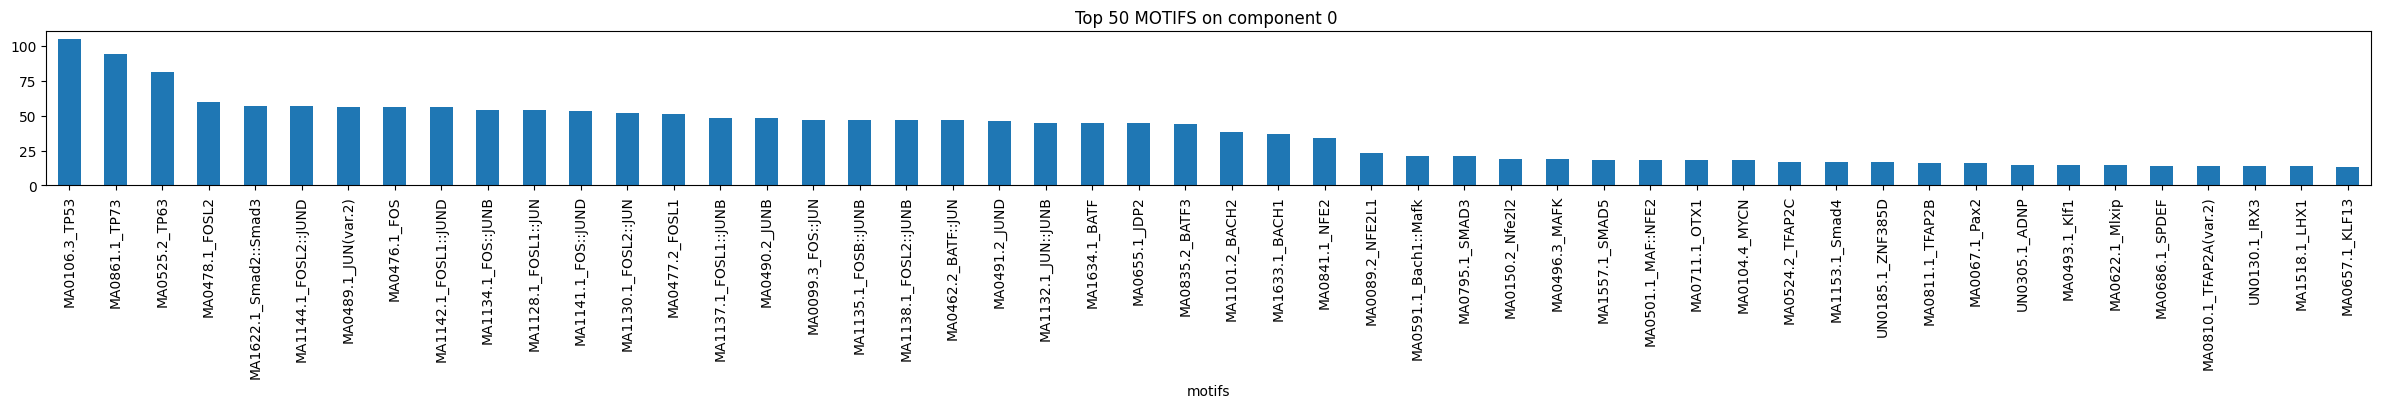

In [45]:
# NEW BLOCK
final_comp_values = {}
for comp, v_comp in df.groupby('component'):
    print(comp)
    save_fasta(v_comp)
    final_comp_values[comp] = motifs_from_fasta('fastq_train_component.fasta', False)

In [46]:
dna_alphabet = ['A', 'C', 'T', 'G']
x_train_seq = np.array(
    [one_hot_encode(x, dna_alphabet, 200) for x in tqdm_notebook(df['raw_sequence']) if 'N' not in x]
)
X_train = x_train_seq
X_train = np.array([x.T.tolist() for x in X_train])
X_train[X_train == 0] = -1
X_train.shape

/tmp/ipykernel_144277/853115864.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  x_train_seq = np.array([one_hot_encode(x, dna_alphabet, 200) for x in tqdm_notebook(df['raw_sequence']) if 'N' not in x ])


  0%|          | 0/8000 [00:00<?, ?it/s]

(8000, 4, 200)

## OVERFIT

In [47]:
# #Case want to test overfiiting (1500epochs)
# X_OVERFIT = np.array(X_train[0].tolist() * 200).reshape(-1,4,200)
# X_train = X_OVERFIT

# Train initialize and Training loop

In [48]:
# changes to conditioning
# conditional training init
cell_types = sorted(list(df.component.unique()))
x_train_cell_type = F.one_hot(torch.from_numpy(df["component"].to_numpy()), len(cell_types))
x_train_cell_type.shape

torch.Size([8000, 16])

In [49]:
# changes to conditioning

tf = T.Compose([T.ToTensor()])
batch_size = 64
seq_dataset = SequenceDataset(seqs=X_train, c=x_train_cell_type, transform=tf)
train_dl = DataLoader(seq_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [50]:
timesteps = 200

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps, beta_end=0.05)
# betas = cosine_beta_schedule(timesteps=timesteps,  s=0.0001 )
# define alphas
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
# sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)


def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

0


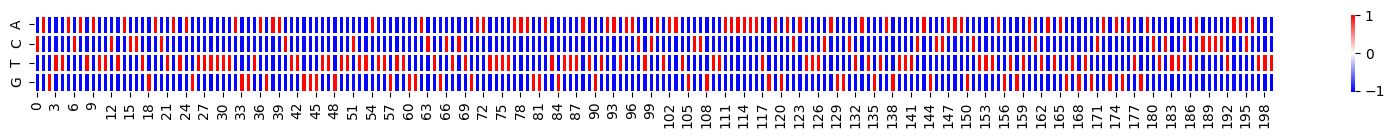

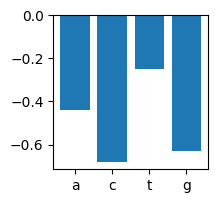

10


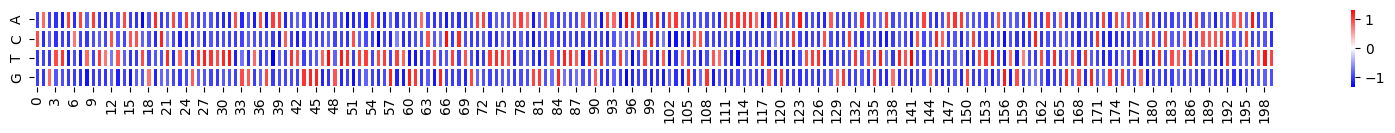

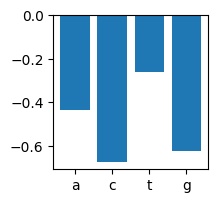

20


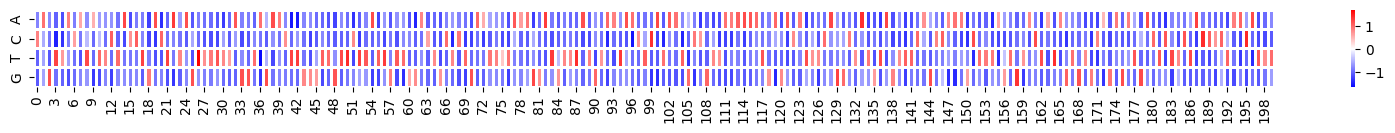

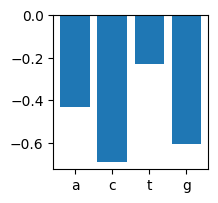

30


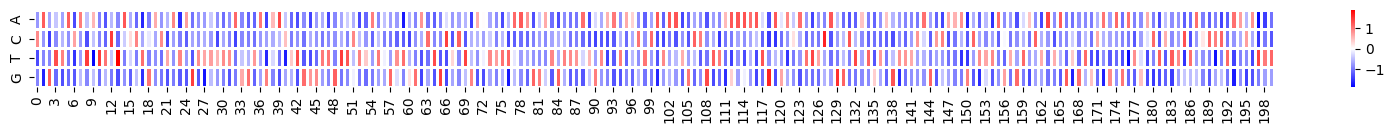

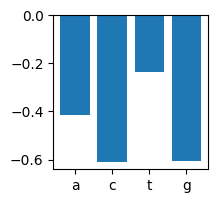

40


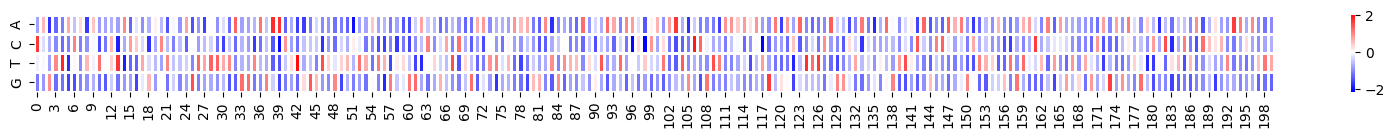

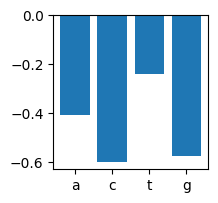

50


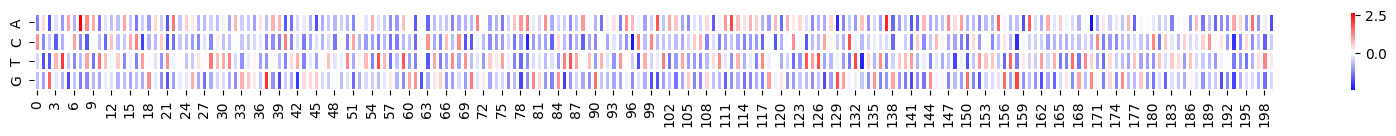

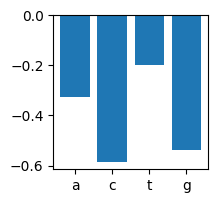

60


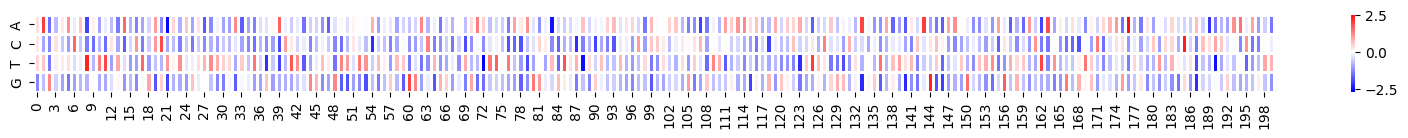

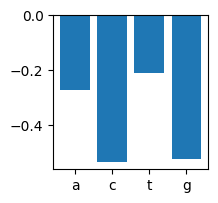

70


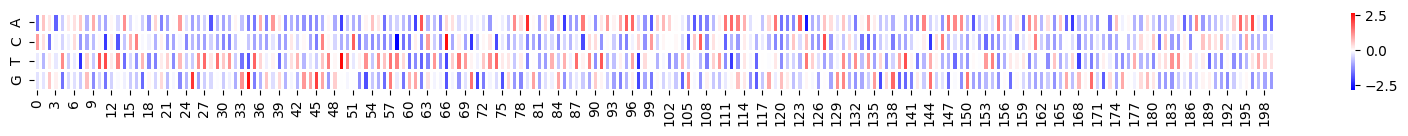

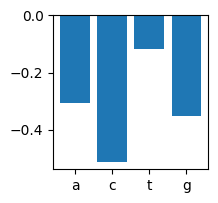

80


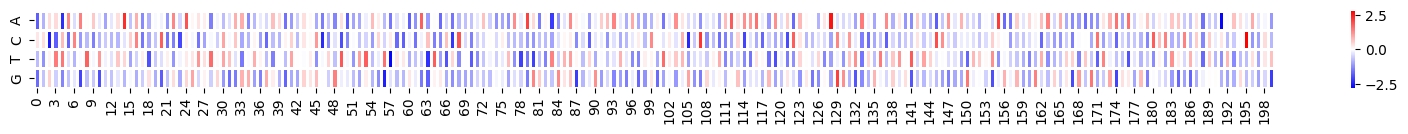

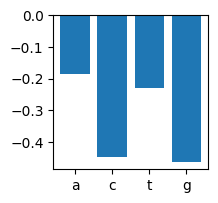

90


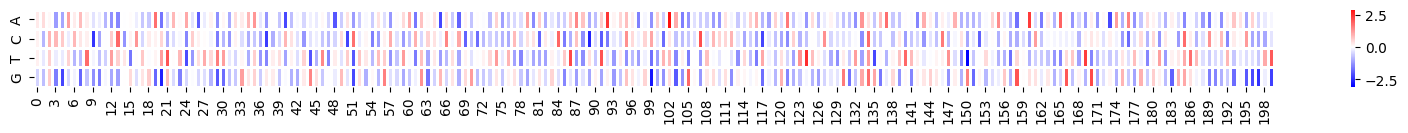

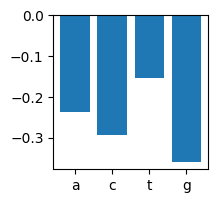

100


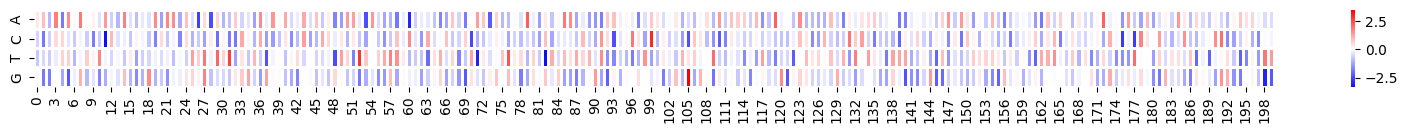

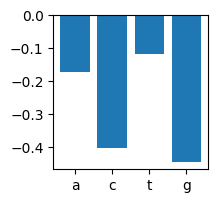

110


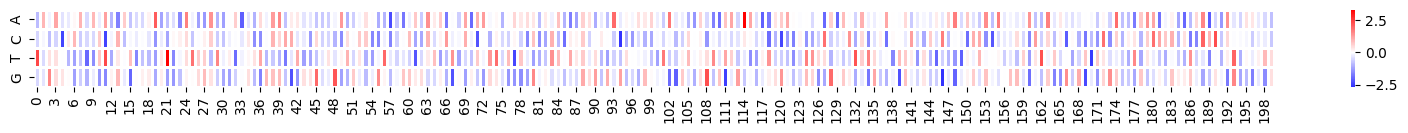

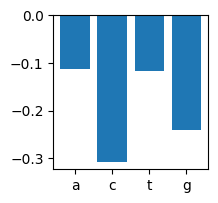

120


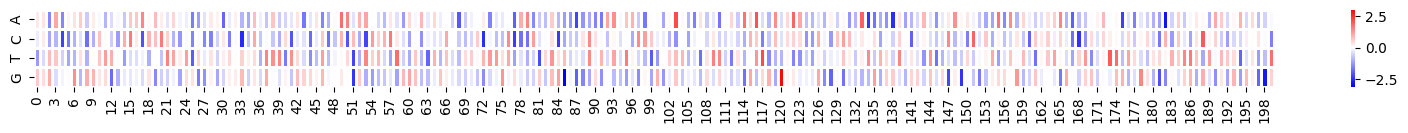

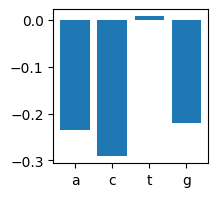

130


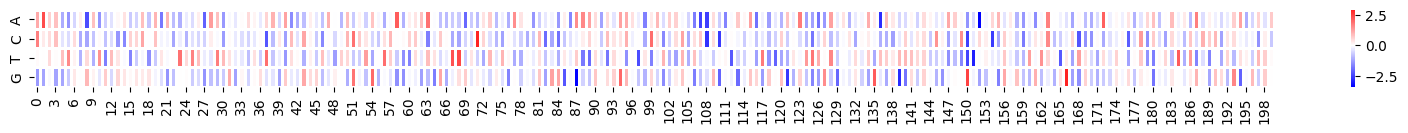

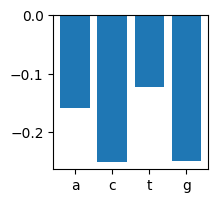

140


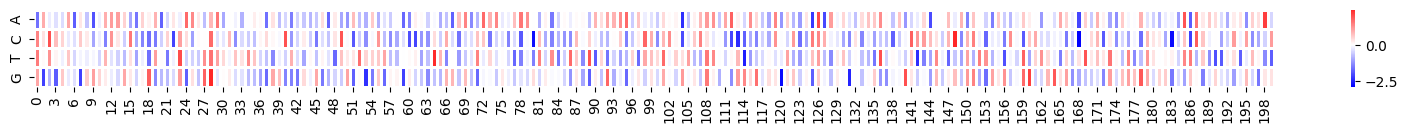

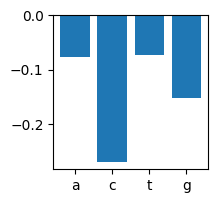

150


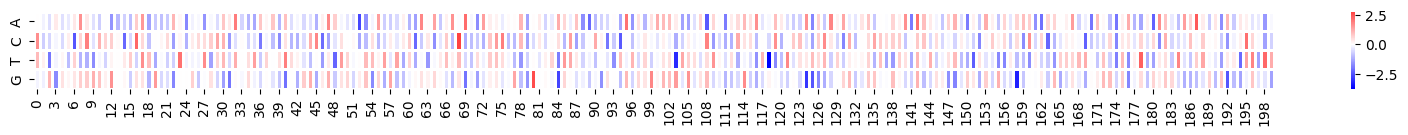

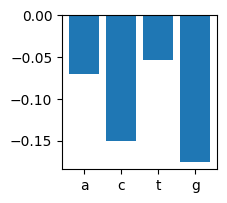

160


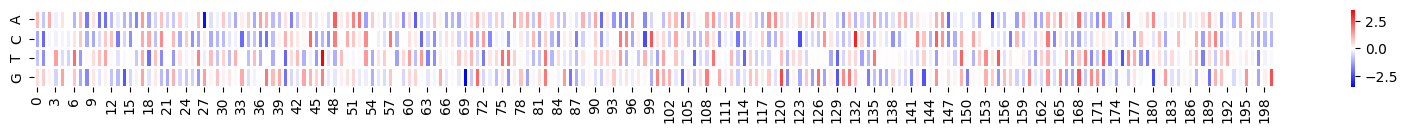

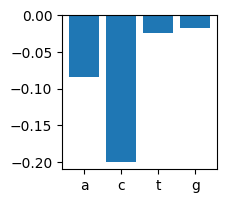

170


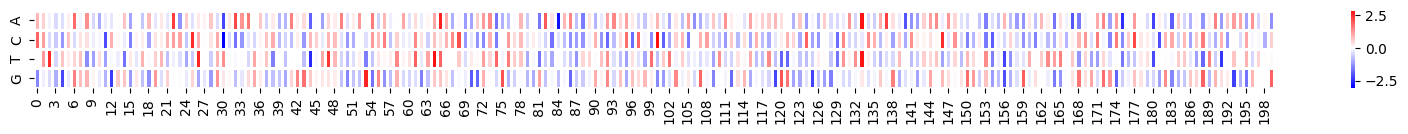

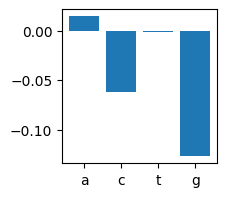

180


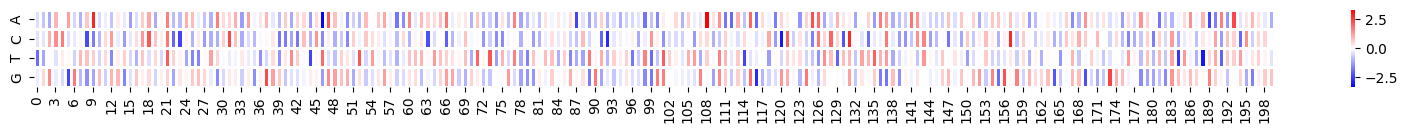

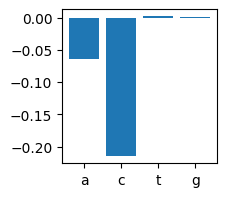

190


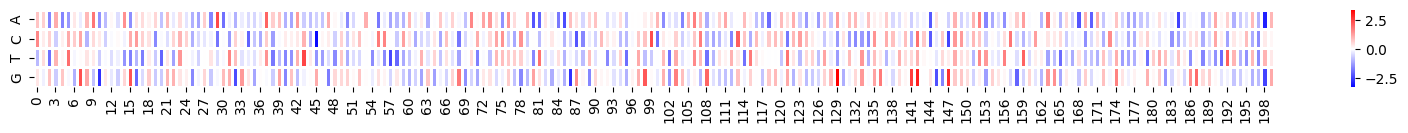

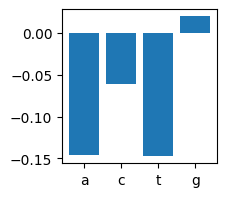

In [51]:
# Ploting images for a  foward pass example
for img_x_show, y in train_dl:
    for i in range(0, timesteps):
        if (i % 10) == 0:
            print(i)
            image_use = q_sample(img_x_show[0], t=torch.tensor([i]))
            image_use_numpy = image_use.numpy()

            plt.rcParams["figure.figsize"] = (20, 1)
            pd_seq = pd.DataFrame(image_use_numpy.reshape(4, 200))

            pd_seq.index = nucleotides
            sns.heatmap(pd_seq, linewidth=1, cmap='bwr', center=0)
            plt.show()
            plt.rcParams["figure.figsize"] = (2, 2)

            plt.bar(['a', 'c', 't', 'g'], pd_seq.mean(1).T)
            plt.show()

    break

In [52]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
print(device)
image_size = 200
channels = 1

model = Unet_lucas(dim=200, channels=1, dim_mults=(1, 2, 4), resnet_block_groups=1, num_classes=len(cell_types)).cuda()

# model = Classifier() # 2d conv

model.to(device)

optimizer = Adam(model.parameters(), lr=1e-4)

  0%|          | 0/10000 [00:00<?, ?it/s]

 Epoch 0 Loss: 0.034796617925167084
 Epoch 10 Loss: 0.0416514053940773
 Epoch 20 Loss: 0.0412721149623394
 Epoch 30 Loss: 0.04056716710329056
 Epoch 40 Loss: 0.03313066437840462
 Epoch 50 Loss: 0.037600327283144
 Epoch 60 Loss: 0.041697196662425995
 Epoch 70 Loss: 0.04461927339434624
 Epoch 80 Loss: 0.030753007158637047
 Epoch 90 Loss: 0.04277394339442253
 Epoch 100 Loss: 0.039622366428375244
saving


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

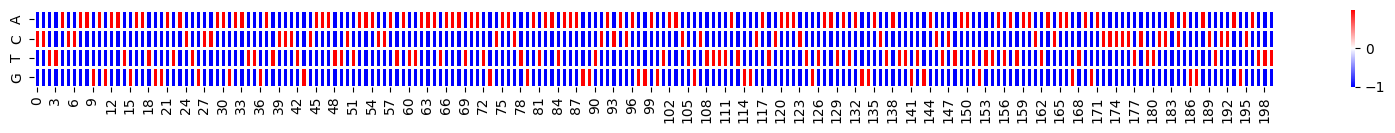

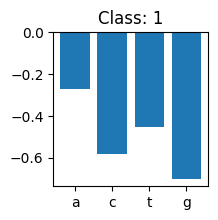

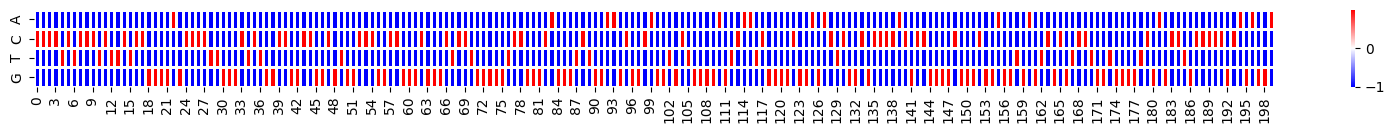

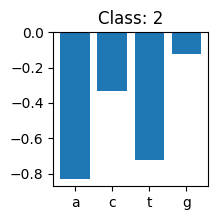

/tmp/ipykernel_144277/12519165.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n_a in tqdm_notebook(range(number_of_samples)): # generating 20*10 sequences


  0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

scanning: 100%|█████████████████████| 1000/1000 [00:11<00:00, 84.75 sequences/s]


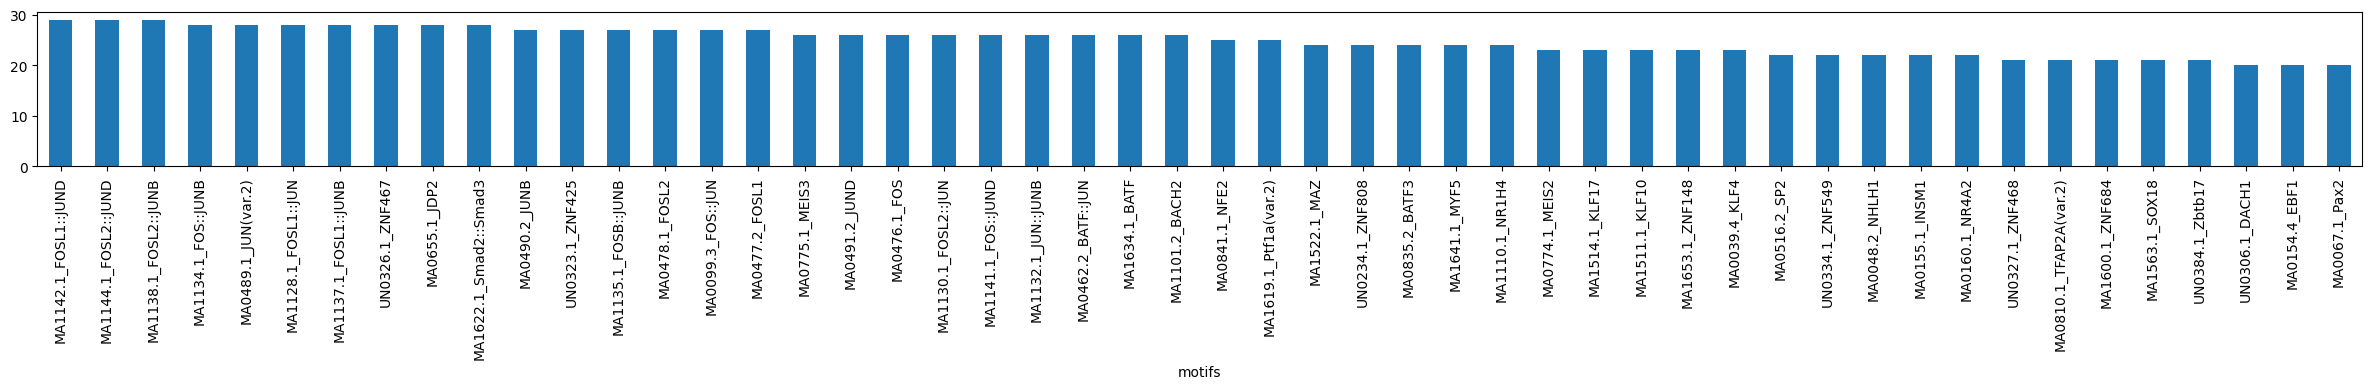

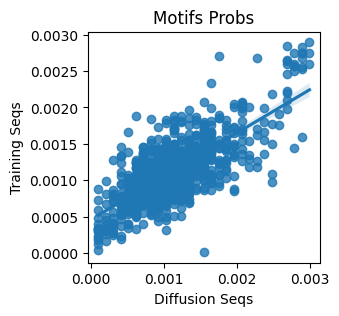

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2       16      119        0.001650       0.001296
1          MA0523.1_TCF7L2        7      125        0.000722       0.001361
2           MA0662.1_MIXL1        6       67        0.000619       0.000729
3          MA1601.1_ZNF75D       14      111        0.001444       0.001209
4           MA0840.1_Creb5       13      116        0.001341       0.001263
..                     ...      ...      ...             ...            ...
878          MA0780.1_PAX3       10       62        0.001031       0.000675
879         MA0883.1_Dmbx1        6       82        0.000619       0.000893
880  MA1539.1_NR2F6(var.3)       11      128        0.001134       0.001394
881           MA0842.2_NRL       12      101        0.001238       0.001100
882          MA0798.2_RFX3        6      117        0.000619       0.001274

[883 rows x 5 columns]

0.060173618755677824 KL
 Epoch 110 Loss: 0.03988584503531456
 Epoch 120 Loss: 0.04471477493643761
 Epoch 130 Loss: 0.04760297015309334
 Epoch 140 Loss: 0.0380982980132103
 Epoch 150 Loss: 0.04660065844655037
 Epoch 160 Loss: 0.034853529185056686
 Epoch 170 Loss: 0.03697724640369415
 Epoch 180 Loss: 0.038106177002191544
 Epoch 190 Loss: 0.03432129696011543
 Epoch 200 Loss: 0.03689512237906456
saving


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

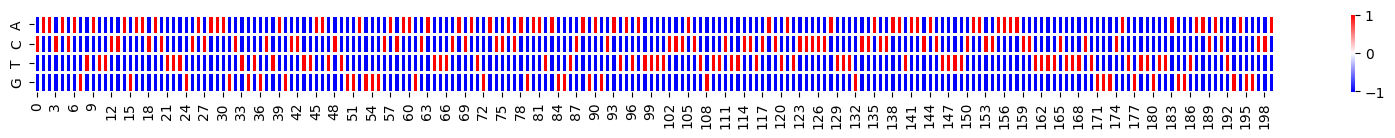

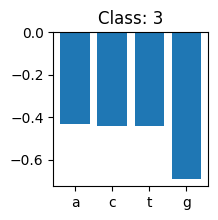

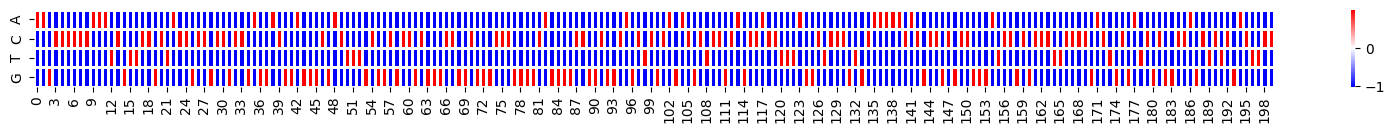

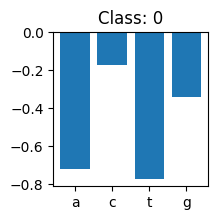

/tmp/ipykernel_144277/12519165.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n_a in tqdm_notebook(range(number_of_samples)): # generating 20*10 sequences


  0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

scanning: 100%|█████████████████████| 1000/1000 [00:11<00:00, 84.30 sequences/s]


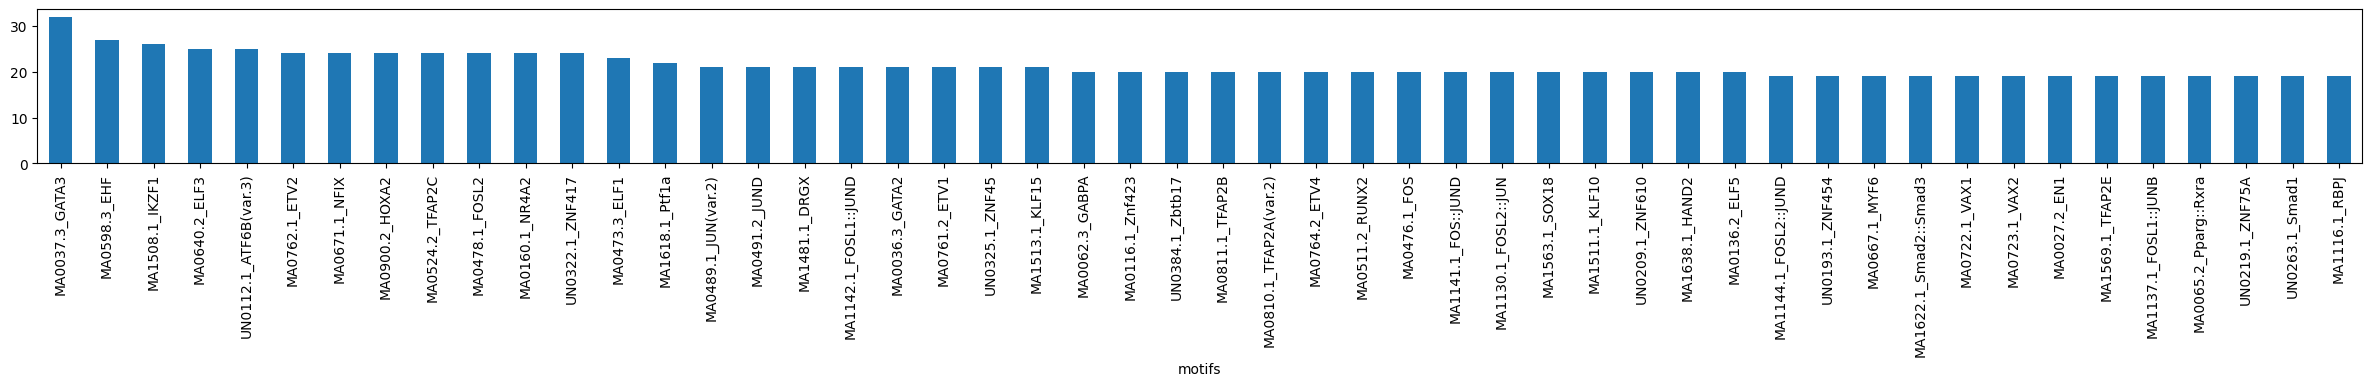

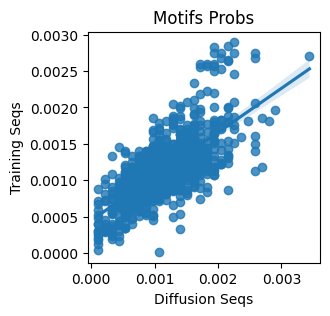

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2       15      119        0.001614       0.001296
1          MA0523.1_TCF7L2        9      125        0.000969       0.001361
2           MA0662.1_MIXL1        4       67        0.000431       0.000729
3          MA1601.1_ZNF75D       17      111        0.001830       0.001209
4           MA0840.1_Creb5        9      116        0.000969       0.001263
..                     ...      ...      ...             ...            ...
878          MA0780.1_PAX3        1       62        0.000108       0.000675
879         MA0883.1_Dmbx1       10       82        0.001076       0.000893
880  MA1539.1_NR2F6(var.3)       17      128        0.001830       0.001394
881           MA0842.2_NRL       14      101        0.001507       0.001100
882          MA0798.2_RFX3       11      117        0.001184       0.001274

[883 rows x 5 columns]

0.05701018389429989 KL
 Epoch 210 Loss: 0.043932028114795685
 Epoch 220 Loss: 0.036190345883369446
 Epoch 230 Loss: 0.03295621648430824
 Epoch 240 Loss: 0.032853927463293076
 Epoch 250 Loss: 0.04412522166967392
 Epoch 260 Loss: 0.03333206847310066
 Epoch 270 Loss: 0.03886570781469345


In [ ]:
# changes to conditioning


epochs = 10000
save_and_sample_every = 100
epochs_loss_show = 10

for epoch in tqdm(range(epochs)):
    for step, batch in enumerate(train_dl):
        x, y = batch
        x = x.type(torch.float32).to(device)
        y = y.type(torch.float32).to(device)
        optimizer.zero_grad()
        # print (batch[0].dtype)
        batch_size = x.shape[0]
        # batch_size = batch["pixel_values"].shape[0]
        # batch = batch["pixel_values"].to(device)
        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()  # sampling a t to generate t and t+1
        # print (t.dtype)
        # loss = p_losses(model, batch, t, loss_type="l2")
        loss = p_losses(model, x, t, y, loss_type="huber")
        loss.backward()
        optimizer.step()

    if (epoch % epochs_loss_show) == 0:
        print(f" Epoch {epoch} Loss:", loss.item())

    # save generated images
    if epoch != 0 and epoch % save_and_sample_every == 0:
        print('saving')
        milestone = step // save_and_sample_every
        sample_bs = 2
        sampled = torch.from_numpy(np.random.randint(0, len(cell_types), size=(sample_bs)))
        random_classes = torch.zeros((sample_bs, len(cell_types)))
        random_classes = random_classes.scatter_(1, sampled.unsqueeze(dim=1), 1).float().cuda()

        samples = sample(model, classes=random_classes, image_size=image_size, batch_size=2, channels=1)
        n_print = 0
        for image, class_show in zip(samples[-1], random_classes.argmax(1).tolist()):
            if n_print < 4:
                plt.rcParams["figure.figsize"] = (20, 1)
                pd_seq = pd.DataFrame(image.reshape(4, 200))
                pd_seq.index = nucleotides
                sns.heatmap(pd_seq, linewidth=1, cmap='bwr', center=0)
                plt.show()
                plt.rcParams["figure.figsize"] = (2, 2)

                plt.bar(['a', 'c', 't', 'g'], pd_seq.mean(1).T)
                plt.title(f'Class: {class_show}')
                plt.show()
                n_print = n_print + 1
        synt_df = sampling_to_metric(100)
        print(compare_motif_list(synt_df, df_results_seq_guime_count), 'KL')

cuda
200 init_dim
final 200 1 Conv2d(200, 1, kernel_size=(1, 1), stride=(1, 1))


In [83]:
# new block
# just a simple saving
torch.save(model, 'UNET_FULL_MODEL_1000_EPOCHS_8K_CELLS.model')

In [52]:
# loading model from memory
# model = torch.load('UNET_FULL_MODEL_2300_EPOCHS_2K_CELLS.model',  map_location=lambda storage, loc: storage.cuda(1))

KeyboardInterrupt: 

In [ ]:
# model = Unet_lucas(

#     dim = 200,
#         channels = 1,
#     dim_mults = (1,2,4),
#     resnet_block_groups = 1,
#     num_classes=len(cell_types)


# ).cuda()


# model.load_state_dict(torch.load('UNET_FULL_MODEL_2300_EPOCHS_2K_CELLS.model'))
# model.to(device_model)

1

## Module metric by component

0


/tmp/ipykernel_144277/12519165.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n_a in tqdm_notebook(range(number_of_samples)): # generating 20*10 sequences


  0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

scanning: 100%|███████████████████████| 500/500 [00:08<00:00, 60.08 sequences/s]


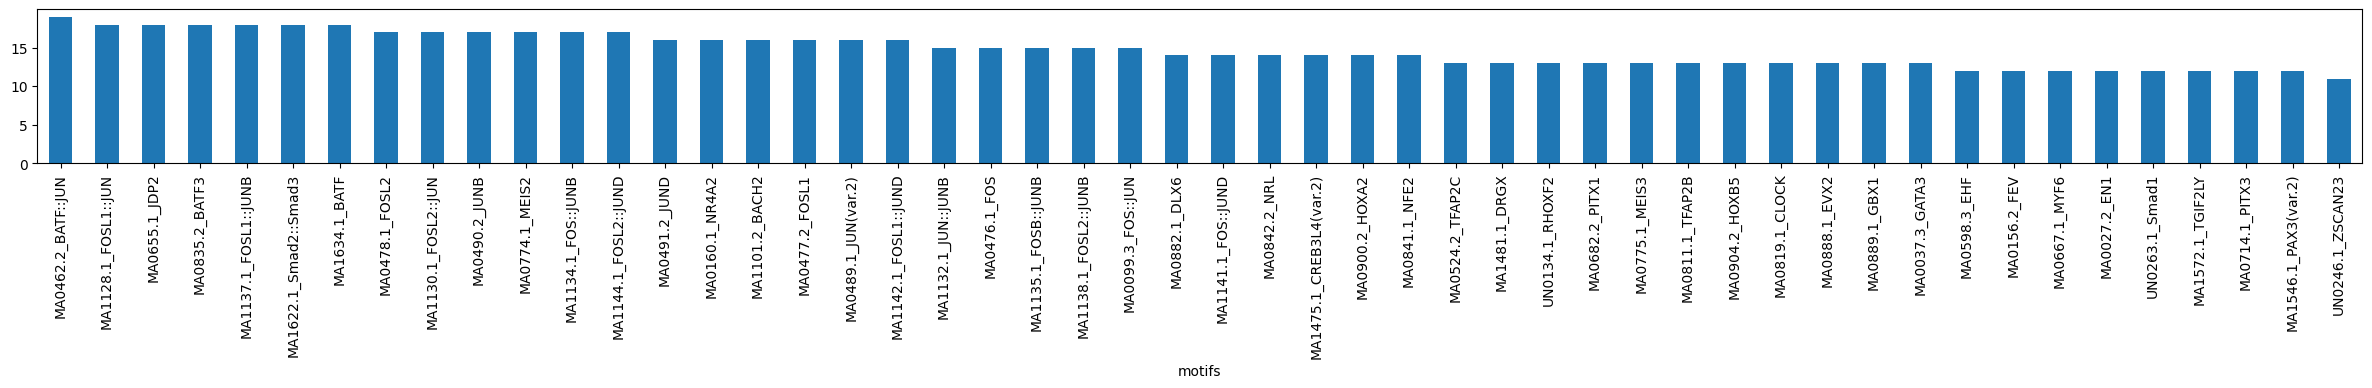

0


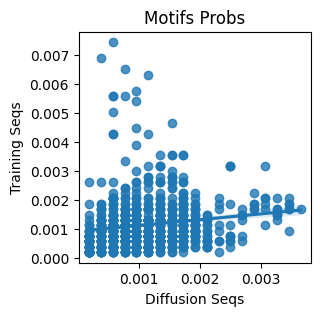

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        2        9        0.000385       0.001676
1          MA0523.1_TCF7L2        7        5        0.001347       0.000931
2           MA0662.1_MIXL1        6        7        0.001155       0.001304
3          MA1601.1_ZNF75D        9        7        0.001732       0.001304
4           MA0840.1_Creb5        9        7        0.001732       0.001304
..                     ...      ...      ...             ...            ...
872          MA0780.1_PAX3        4        7        0.000770       0.001304
873         MA0883.1_Dmbx1        6        1        0.001155       0.000186
874  MA1539.1_NR2F6(var.3)        5        5        0.000962       0.000931
875           MA0842.2_NRL       14        7        0.002694       0.001304
876          MA0798.2_RFX3        3        5        0.000577       0.000931

[877 rows x 5 columns]

0 0 0.30060232696206535
1


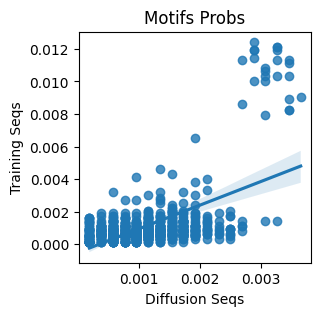

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        2        4        0.000385       0.000636
1          MA0523.1_TCF7L2        7        2        0.001347       0.000318
2           MA0662.1_MIXL1        6        3        0.001155       0.000477
3          MA1601.1_ZNF75D        9        8        0.001732       0.001272
4           MA0840.1_Creb5        9        9        0.001732       0.001432
..                     ...      ...      ...             ...            ...
872          MA0780.1_PAX3        4        1        0.000770       0.000159
873         MA0883.1_Dmbx1        6        9        0.001155       0.001432
874  MA1539.1_NR2F6(var.3)        5        8        0.000962       0.001272
875           MA0842.2_NRL       14        9        0.002694       0.001432
876          MA0798.2_RFX3        3        6        0.000577       0.000954

[877 rows x 5 columns]

0 1 0.32756078041023795
2


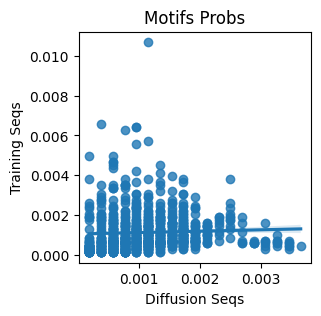

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        2       18        0.000385       0.002632
1          MA0523.1_TCF7L2        7       12        0.001347       0.001755
2           MA0662.1_MIXL1        6        4        0.001155       0.000585
3          MA1601.1_ZNF75D        9        6        0.001732       0.000877
4           MA0840.1_Creb5        9        3        0.001732       0.000439
..                     ...      ...      ...             ...            ...
872          MA0780.1_PAX3        4        2        0.000770       0.000292
873         MA0883.1_Dmbx1        6        9        0.001155       0.001316
874  MA1539.1_NR2F6(var.3)        5        9        0.000962       0.001316
875           MA0842.2_NRL       14        8        0.002694       0.001170
876          MA0798.2_RFX3        3       11        0.000577       0.001608

[877 rows x 5 columns]

0 2 0.3830095231218785
3


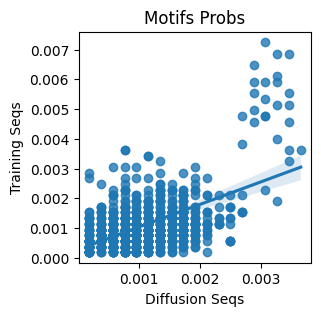

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        2        2        0.000385       0.000381
1          MA0523.1_TCF7L2        7       10        0.001347       0.001907
2           MA0662.1_MIXL1        6        2        0.001155       0.000381
3          MA1601.1_ZNF75D        9       10        0.001732       0.001907
4           MA0840.1_Creb5        9        6        0.001732       0.001144
..                     ...      ...      ...             ...            ...
871          MA0780.1_PAX3        4        1        0.000770       0.000191
872         MA0883.1_Dmbx1        6        5        0.001155       0.000953
873  MA1539.1_NR2F6(var.3)        5        3        0.000962       0.000572
874           MA0842.2_NRL       14        8        0.002694       0.001526
875          MA0798.2_RFX3        3        8        0.000577       0.001526

[876 rows x 5 columns]

0 3 0.21948784684697278
4


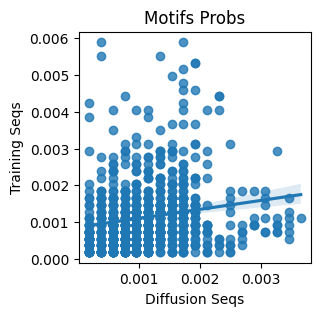

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        2        3        0.000385       0.000552
1          MA0523.1_TCF7L2        7       16        0.001347       0.002944
2           MA0662.1_MIXL1        6        1        0.001154       0.000184
3          MA1601.1_ZNF75D        9        7        0.001731       0.001288
4           MA0840.1_Creb5        9        6        0.001731       0.001104
..                     ...      ...      ...             ...            ...
873          MA0780.1_PAX3        4        2        0.000770       0.000368
874         MA0883.1_Dmbx1        6        1        0.001154       0.000184
875  MA1539.1_NR2F6(var.3)        5        6        0.000962       0.001104
876           MA0842.2_NRL       14        3        0.002693       0.000552
877          MA0798.2_RFX3        3        7        0.000577       0.001288

[878 rows x 5 columns]

0 4 0.36557742188871856
5


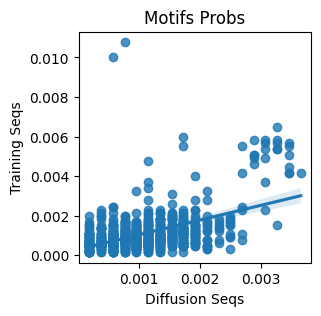

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        2        7        0.000384       0.001077
1          MA0523.1_TCF7L2        7       10        0.001345       0.001539
2           MA0662.1_MIXL1        6        4        0.001153       0.000615
3          MA1601.1_ZNF75D        9        6        0.001730       0.000923
4           MA0840.1_Creb5        9       12        0.001730       0.001846
..                     ...      ...      ...             ...            ...
878          MA0780.1_PAX3        4        6        0.000769       0.000923
879         MA0883.1_Dmbx1        6        8        0.001153       0.001231
880  MA1539.1_NR2F6(var.3)        5        7        0.000961       0.001077
881           MA0842.2_NRL       14        7        0.002691       0.001077
882          MA0798.2_RFX3        3        5        0.000577       0.000769

[883 rows x 5 columns]

0 5 0.22591647035122003
6


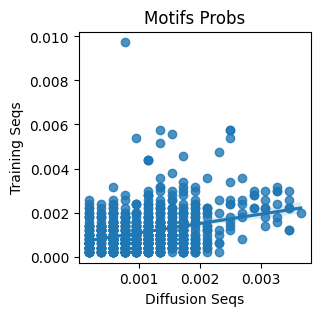

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        2        4        0.000384       0.000795
1          MA0523.1_TCF7L2        7        3        0.001346       0.000596
2           MA0662.1_MIXL1        6        3        0.001153       0.000596
3          MA1601.1_ZNF75D        9        8        0.001730       0.001590
4           MA0840.1_Creb5        9        9        0.001730       0.001788
..                     ...      ...      ...             ...            ...
877          MA0780.1_PAX3        4        1        0.000769       0.000199
878         MA0883.1_Dmbx1        6        3        0.001153       0.000596
879  MA1539.1_NR2F6(var.3)        5       10        0.000961       0.001987
880           MA0842.2_NRL       14        4        0.002691       0.000795
881          MA0798.2_RFX3        3        7        0.000577       0.001391

[882 rows x 5 columns]

0 6 0.31399853958807245
7


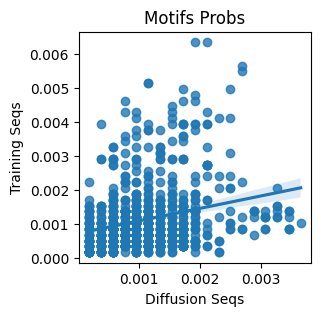

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        2        6        0.000385       0.001028
1          MA0523.1_TCF7L2        7       13        0.001347       0.002228
2           MA0662.1_MIXL1        6       22        0.001155       0.003770
3          MA1601.1_ZNF75D        9        4        0.001732       0.000685
4           MA0840.1_Creb5        9        5        0.001732       0.000857
..                     ...      ...      ...             ...            ...
870          MA0780.1_PAX3        4       12        0.000770       0.002056
871         MA0883.1_Dmbx1        6        5        0.001155       0.000857
872  MA1539.1_NR2F6(var.3)        5        2        0.000962       0.000343
873           MA0842.2_NRL       14       13        0.002695       0.002228
874          MA0798.2_RFX3        3       19        0.000577       0.003256

[875 rows x 5 columns]

0 7 0.3365343210015801
8


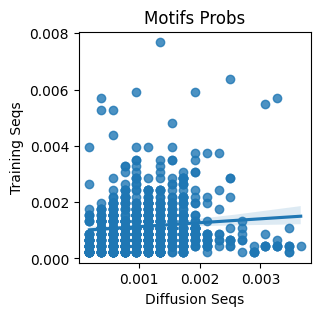

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        2        8        0.000385       0.001756
1          MA0523.1_TCF7L2        7        3        0.001348       0.000658
2           MA0662.1_MIXL1        6        2        0.001156       0.000439
3          MA1601.1_ZNF75D        9        3        0.001734       0.000658
4           MA0840.1_Creb5        9        3        0.001734       0.000658
..                     ...      ...      ...             ...            ...
866          MA0780.1_PAX3        4        3        0.000771       0.000658
867         MA0883.1_Dmbx1        6        2        0.001156       0.000439
868  MA1539.1_NR2F6(var.3)        5        9        0.000963       0.001975
869           MA0842.2_NRL       14        6        0.002697       0.001317
870          MA0798.2_RFX3        3        6        0.000578       0.001317

[871 rows x 5 columns]

0 8 0.3979171986329991
9


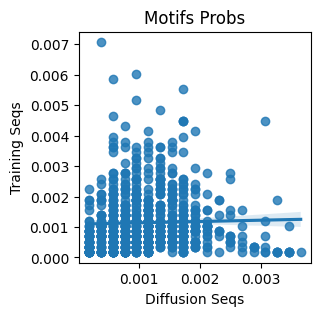

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        2       11        0.000385       0.001897
1          MA0523.1_TCF7L2        7        7        0.001348       0.001207
2           MA0662.1_MIXL1        6        9        0.001155       0.001552
3          MA1601.1_ZNF75D        9        6        0.001733       0.001034
4           MA0840.1_Creb5        9        2        0.001733       0.000345
..                     ...      ...      ...             ...            ...
869          MA0780.1_PAX3        4        3        0.000770       0.000517
870         MA0883.1_Dmbx1        6        6        0.001155       0.001034
871  MA1539.1_NR2F6(var.3)        5       15        0.000963       0.002586
872           MA0842.2_NRL       14        4        0.002695       0.000690
873          MA0798.2_RFX3        3        7        0.000578       0.001207

[874 rows x 5 columns]

0 9 0.4605930402545635
10


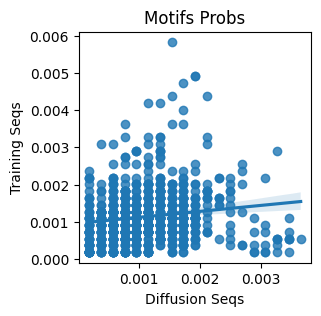

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        2        7        0.000385       0.001274
1          MA0523.1_TCF7L2        7        9        0.001347       0.001638
2           MA0662.1_MIXL1        6        4        0.001155       0.000728
3          MA1601.1_ZNF75D        9        6        0.001732       0.001092
4           MA0840.1_Creb5        9        5        0.001732       0.000910
..                     ...      ...      ...             ...            ...
871          MA0780.1_PAX3        4        6        0.000770       0.001092
872         MA0883.1_Dmbx1        6        5        0.001155       0.000910
873  MA1539.1_NR2F6(var.3)        5        4        0.000962       0.000728
874           MA0842.2_NRL       14       13        0.002694       0.002365
875          MA0798.2_RFX3        3        7        0.000577       0.001274

[876 rows x 5 columns]

0 10 0.31591691767446695
11


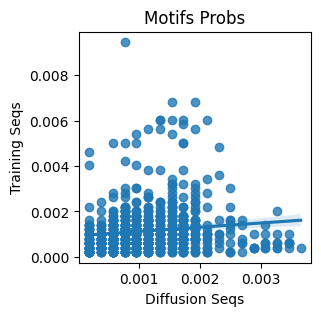

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        2        4        0.000385       0.000805
1          MA0523.1_TCF7L2        7        8        0.001347       0.001610
2           MA0662.1_MIXL1        6        1        0.001155       0.000201
3          MA1601.1_ZNF75D        9        5        0.001732       0.001006
4           MA0840.1_Creb5        9        9        0.001732       0.001811
..                     ...      ...      ...             ...            ...
871          MA0780.1_PAX3        4        4        0.000770       0.000805
872         MA0883.1_Dmbx1        6        7        0.001155       0.001408
873  MA1539.1_NR2F6(var.3)        5        9        0.000962       0.001811
874           MA0842.2_NRL       14        7        0.002694       0.001408
875          MA0798.2_RFX3        3        9        0.000577       0.001811

[876 rows x 5 columns]

0 11 0.3890793358011253
12


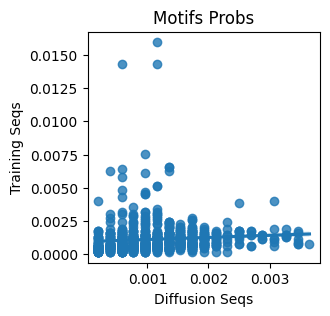

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        2       10        0.000385       0.001611
1          MA0523.1_TCF7L2        7       14        0.001346       0.002255
2           MA0662.1_MIXL1        6        3        0.001154       0.000483
3          MA1601.1_ZNF75D        9        5        0.001731       0.000805
4           MA0840.1_Creb5        9        7        0.001731       0.001127
..                     ...      ...      ...             ...            ...
874          MA0780.1_PAX3        4        5        0.000769       0.000805
875         MA0883.1_Dmbx1        6        3        0.001154       0.000483
876  MA1539.1_NR2F6(var.3)        5       20        0.000962       0.003221
877           MA0842.2_NRL       14        4        0.002693       0.000644
878          MA0798.2_RFX3        3        8        0.000577       0.001288

[879 rows x 5 columns]

0 12 0.3307531237052193
13


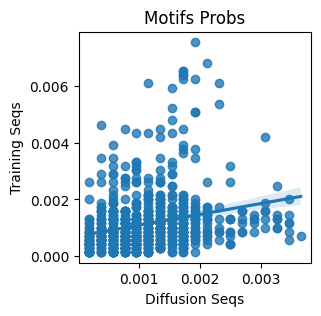

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        2        7        0.000385       0.001014
1          MA0523.1_TCF7L2        7        4        0.001348       0.000579
2           MA0662.1_MIXL1        6        4        0.001156       0.000579
3          MA1601.1_ZNF75D        9       11        0.001733       0.001593
4           MA0840.1_Creb5        9        8        0.001733       0.001158
..                     ...      ...      ...             ...            ...
867          MA0780.1_PAX3        4        2        0.000770       0.000290
868         MA0883.1_Dmbx1        6        2        0.001156       0.000290
869  MA1539.1_NR2F6(var.3)        5        8        0.000963       0.001158
870           MA0842.2_NRL       14        6        0.002696       0.000869
871          MA0798.2_RFX3        3       11        0.000578       0.001593

[872 rows x 5 columns]

0 13 0.32151808298205936
14


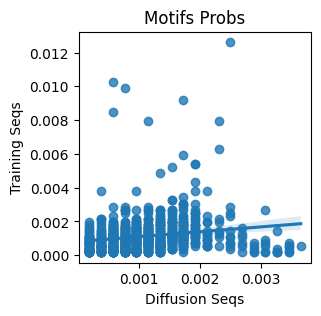

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        2       12        0.000385       0.002162
1          MA0523.1_TCF7L2        7        5        0.001347       0.000901
2           MA0662.1_MIXL1        6        1        0.001155       0.000180
3          MA1601.1_ZNF75D        9       10        0.001732       0.001802
4           MA0840.1_Creb5        9        7        0.001732       0.001261
..                     ...      ...      ...             ...            ...
872          MA0780.1_PAX3        4        2        0.000770       0.000360
873         MA0883.1_Dmbx1        6        6        0.001155       0.001081
874  MA1539.1_NR2F6(var.3)        5        6        0.000962       0.001081
875           MA0842.2_NRL       14        4        0.002694       0.000721
876          MA0798.2_RFX3        3        1        0.000577       0.000180

[877 rows x 5 columns]

0 14 0.3776755481106947
15


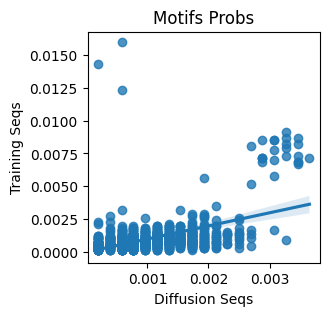

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        2        7        0.000385       0.001063
1          MA0523.1_TCF7L2        7        4        0.001346       0.000608
2           MA0662.1_MIXL1        6        2        0.001154       0.000304
3          MA1601.1_ZNF75D        9        9        0.001731       0.001367
4           MA0840.1_Creb5        9        5        0.001731       0.000759
..                     ...      ...      ...             ...            ...
874          MA0780.1_PAX3        4        1        0.000769       0.000152
875         MA0883.1_Dmbx1        6       10        0.001154       0.001519
876  MA1539.1_NR2F6(var.3)        5        7        0.000962       0.001063
877           MA0842.2_NRL       14        3        0.002693       0.000456
878          MA0798.2_RFX3        3        5        0.000577       0.000759

[879 rows x 5 columns]

0 15 0.2944579794654486
1


/tmp/ipykernel_144277/12519165.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n_a in tqdm_notebook(range(number_of_samples)): # generating 20*10 sequences


  0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

scanning: 100%|███████████████████████| 500/500 [00:08<00:00, 58.11 sequences/s]


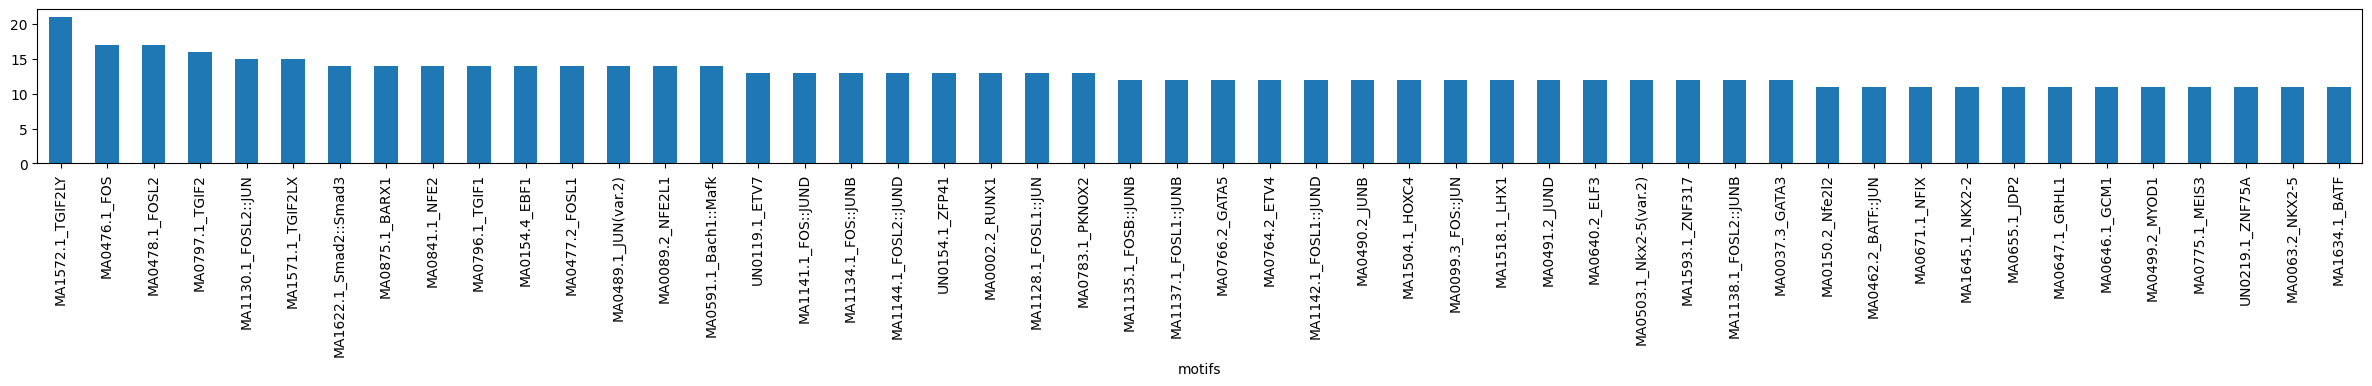

0


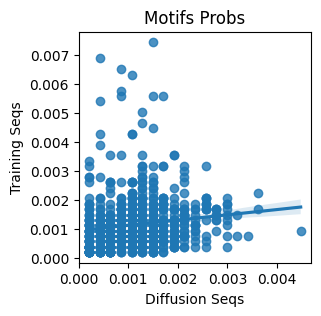

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        2        9        0.000426       0.001677
1          MA0523.1_TCF7L2        7        5        0.001493       0.000932
2           MA0662.1_MIXL1        1        7        0.000213       0.001305
3          MA1601.1_ZNF75D       10        7        0.002132       0.001305
4           MA0840.1_Creb5        4        7        0.000853       0.001305
..                     ...      ...      ...             ...            ...
868          MA0780.1_PAX3        4        7        0.000853       0.001305
869         MA0883.1_Dmbx1        2        1        0.000426       0.000186
870  MA1539.1_NR2F6(var.3)        5        5        0.001066       0.000932
871           MA0842.2_NRL        6        7        0.001279       0.001305
872          MA0798.2_RFX3        1        5        0.000213       0.000932

[873 rows x 5 columns]

1 0 0.3084097402134635
1


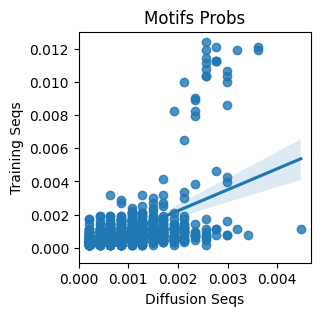

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        2        4        0.000426       0.000636
1          MA0523.1_TCF7L2        7        2        0.001492       0.000318
2           MA0662.1_MIXL1        1        3        0.000213       0.000477
3          MA1601.1_ZNF75D       10        8        0.002131       0.001273
4           MA0840.1_Creb5        4        9        0.000853       0.001432
..                     ...      ...      ...             ...            ...
870          MA0780.1_PAX3        4        1        0.000853       0.000159
871         MA0883.1_Dmbx1        2        9        0.000426       0.001432
872  MA1539.1_NR2F6(var.3)        5        8        0.001066       0.001273
873           MA0842.2_NRL        6        9        0.001279       0.001432
874          MA0798.2_RFX3        1        6        0.000213       0.000955

[875 rows x 5 columns]

1 1 0.3393844257688666
2


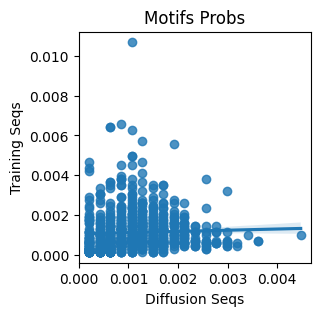

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        2       18        0.000426       0.002631
1          MA0523.1_TCF7L2        7       12        0.001491       0.001754
2           MA0662.1_MIXL1        1        4        0.000213       0.000585
3          MA1601.1_ZNF75D       10        6        0.002129       0.000877
4           MA0840.1_Creb5        4        3        0.000852       0.000439
..                     ...      ...      ...             ...            ...
874          MA0780.1_PAX3        4        2        0.000852       0.000292
875         MA0883.1_Dmbx1        2        9        0.000426       0.001316
876  MA1539.1_NR2F6(var.3)        5        9        0.001065       0.001316
877           MA0842.2_NRL        6        8        0.001278       0.001169
878          MA0798.2_RFX3        1       11        0.000213       0.001608

[879 rows x 5 columns]

1 2 0.3987539787214408
3


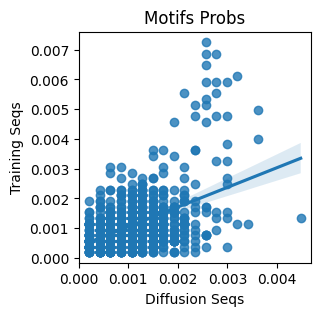

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        2        2        0.000427       0.000382
1          MA0523.1_TCF7L2        7       10        0.001493       0.001908
2           MA0662.1_MIXL1        1        2        0.000213       0.000382
3          MA1601.1_ZNF75D       10       10        0.002133       0.001908
4           MA0840.1_Creb5        4        6        0.000853       0.001145
..                     ...      ...      ...             ...            ...
867          MA0780.1_PAX3        4        1        0.000853       0.000191
868         MA0883.1_Dmbx1        2        5        0.000427       0.000954
869  MA1539.1_NR2F6(var.3)        5        3        0.001066       0.000573
870           MA0842.2_NRL        6        8        0.001280       0.001527
871          MA0798.2_RFX3        1        8        0.000213       0.001527

[872 rows x 5 columns]

1 3 0.24237427855138288
4


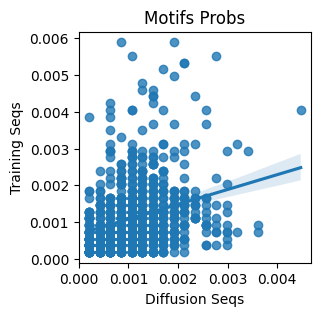

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        2        3        0.000426       0.000552
1          MA0523.1_TCF7L2        7       16        0.001491       0.002944
2           MA0662.1_MIXL1        1        1        0.000213       0.000184
3          MA1601.1_ZNF75D       10        7        0.002129       0.001288
4           MA0840.1_Creb5        4        6        0.000852       0.001104
..                     ...      ...      ...             ...            ...
874          MA0780.1_PAX3        4        2        0.000852       0.000368
875         MA0883.1_Dmbx1        2        1        0.000426       0.000184
876  MA1539.1_NR2F6(var.3)        5        6        0.001065       0.001104
877           MA0842.2_NRL        6        3        0.001278       0.000552
878          MA0798.2_RFX3        1        7        0.000213       0.001288

[879 rows x 5 columns]

1 4 0.3107605133924253
5


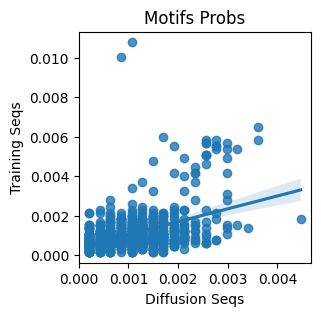

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        2        7        0.000426       0.001077
1          MA0523.1_TCF7L2        7       10        0.001490       0.001539
2           MA0662.1_MIXL1        1        4        0.000213       0.000616
3          MA1601.1_ZNF75D       10        6        0.002128       0.000923
4           MA0840.1_Creb5        4       12        0.000851       0.001847
..                     ...      ...      ...             ...            ...
877          MA0780.1_PAX3        4        6        0.000851       0.000923
878         MA0883.1_Dmbx1        2        8        0.000426       0.001231
879  MA1539.1_NR2F6(var.3)        5        7        0.001064       0.001077
880           MA0842.2_NRL        6        7        0.001277       0.001077
881          MA0798.2_RFX3        1        5        0.000213       0.000769

[882 rows x 5 columns]

1 5 0.2482053366010041
6


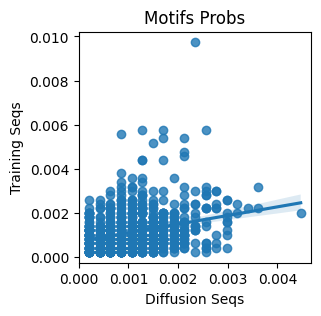

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        2        4        0.000426       0.000795
1          MA0523.1_TCF7L2        7        3        0.001490       0.000596
2           MA0662.1_MIXL1        1        3        0.000213       0.000596
3          MA1601.1_ZNF75D       10        8        0.002129       0.001590
4           MA0840.1_Creb5        4        9        0.000852       0.001789
..                     ...      ...      ...             ...            ...
875          MA0780.1_PAX3        4        1        0.000852       0.000199
876         MA0883.1_Dmbx1        2        3        0.000426       0.000596
877  MA1539.1_NR2F6(var.3)        5       10        0.001065       0.001988
878           MA0842.2_NRL        6        4        0.001277       0.000795
879          MA0798.2_RFX3        1        7        0.000213       0.001391

[880 rows x 5 columns]

1 6 0.3097950814935906
7


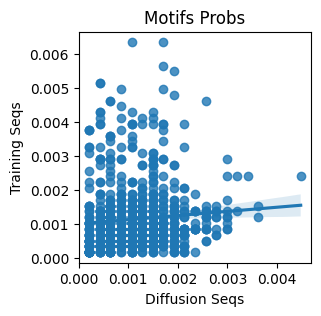

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        2        6        0.000427       0.001029
1          MA0523.1_TCF7L2        7       13        0.001493       0.002229
2           MA0662.1_MIXL1        1       22        0.000213       0.003772
3          MA1601.1_ZNF75D       10        4        0.002133       0.000686
4           MA0840.1_Creb5        4        5        0.000853       0.000857
..                     ...      ...      ...             ...            ...
867          MA0780.1_PAX3        4       12        0.000853       0.002057
868         MA0883.1_Dmbx1        2        5        0.000427       0.000857
869  MA1539.1_NR2F6(var.3)        5        2        0.001066       0.000343
870           MA0842.2_NRL        6       13        0.001280       0.002229
871          MA0798.2_RFX3        1       19        0.000213       0.003257

[872 rows x 5 columns]

1 7 0.3781122818402005
8


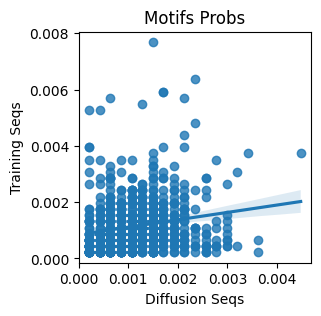

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        2        8        0.000427       0.001757
1          MA0523.1_TCF7L2        7        3        0.001494       0.000659
2           MA0662.1_MIXL1        1        2        0.000213       0.000439
3          MA1601.1_ZNF75D       10        3        0.002134       0.000659
4           MA0840.1_Creb5        4        3        0.000854       0.000659
..                     ...      ...      ...             ...            ...
864          MA0780.1_PAX3        4        3        0.000854       0.000659
865         MA0883.1_Dmbx1        2        2        0.000427       0.000439
866  MA1539.1_NR2F6(var.3)        5        9        0.001067       0.001976
867           MA0842.2_NRL        6        6        0.001280       0.001318
868          MA0798.2_RFX3        1        6        0.000213       0.001318

[869 rows x 5 columns]

1 8 0.3455946308084146
9


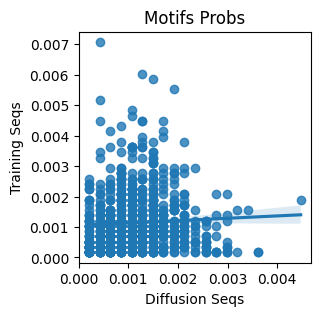

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        2       11        0.000426       0.001896
1          MA0523.1_TCF7L2        7        7        0.001492       0.001207
2           MA0662.1_MIXL1        1        9        0.000213       0.001551
3          MA1601.1_ZNF75D       10        6        0.002131       0.001034
4           MA0840.1_Creb5        4        2        0.000853       0.000345
..                     ...      ...      ...             ...            ...
870          MA0780.1_PAX3        4        3        0.000853       0.000517
871         MA0883.1_Dmbx1        2        6        0.000426       0.001034
872  MA1539.1_NR2F6(var.3)        5       15        0.001066       0.002586
873           MA0842.2_NRL        6        4        0.001279       0.000690
874          MA0798.2_RFX3        1        7        0.000213       0.001207

[875 rows x 5 columns]

1 9 0.44491405148296925
10


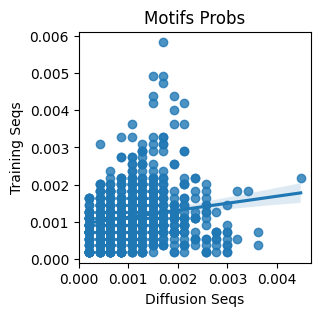

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        2        7        0.000427       0.001275
1          MA0523.1_TCF7L2        7        9        0.001494       0.001640
2           MA0662.1_MIXL1        1        4        0.000213       0.000729
3          MA1601.1_ZNF75D       10        6        0.002134       0.001093
4           MA0840.1_Creb5        4        5        0.000854       0.000911
..                     ...      ...      ...             ...            ...
864          MA0780.1_PAX3        4        6        0.000854       0.001093
865         MA0883.1_Dmbx1        2        5        0.000427       0.000911
866  MA1539.1_NR2F6(var.3)        5        4        0.001067       0.000729
867           MA0842.2_NRL        6       13        0.001280       0.002368
868          MA0798.2_RFX3        1        7        0.000213       0.001275

[869 rows x 5 columns]

1 10 0.3007666072209896
11


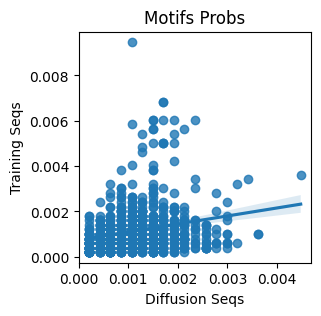

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        2        4        0.000427       0.000806
1          MA0523.1_TCF7L2        7        8        0.001493       0.001612
2           MA0662.1_MIXL1        1        1        0.000213       0.000201
3          MA1601.1_ZNF75D       10        5        0.002134       0.001007
4           MA0840.1_Creb5        4        9        0.000853       0.001813
..                     ...      ...      ...             ...            ...
865          MA0780.1_PAX3        4        4        0.000853       0.000806
866         MA0883.1_Dmbx1        2        7        0.000427       0.001410
867  MA1539.1_NR2F6(var.3)        5        9        0.001067       0.001813
868           MA0842.2_NRL        6        7        0.001280       0.001410
869          MA0798.2_RFX3        1        9        0.000213       0.001813

[870 rows x 5 columns]

1 11 0.33403948977157427
12


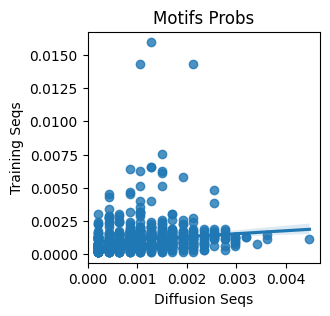

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        2       10        0.000426       0.001611
1          MA0523.1_TCF7L2        7       14        0.001491       0.002255
2           MA0662.1_MIXL1        1        3        0.000213       0.000483
3          MA1601.1_ZNF75D       10        5        0.002129       0.000805
4           MA0840.1_Creb5        4        7        0.000852       0.001127
..                     ...      ...      ...             ...            ...
874          MA0780.1_PAX3        4        5        0.000852       0.000805
875         MA0883.1_Dmbx1        2        3        0.000426       0.000483
876  MA1539.1_NR2F6(var.3)        5       20        0.001065       0.003221
877           MA0842.2_NRL        6        4        0.001278       0.000644
878          MA0798.2_RFX3        1        8        0.000213       0.001288

[879 rows x 5 columns]

1 12 0.33587531747695054
13


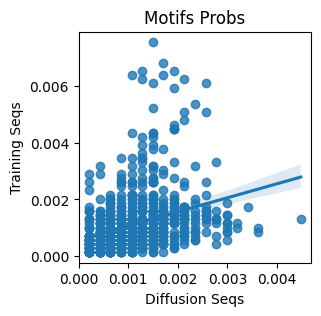

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        2        7        0.000427       0.001014
1          MA0523.1_TCF7L2        7        4        0.001493       0.000579
2           MA0662.1_MIXL1        1        4        0.000213       0.000579
3          MA1601.1_ZNF75D       10       11        0.002134       0.001593
4           MA0840.1_Creb5        4        8        0.000853       0.001159
..                     ...      ...      ...             ...            ...
865          MA0780.1_PAX3        4        2        0.000853       0.000290
866         MA0883.1_Dmbx1        2        2        0.000427       0.000290
867  MA1539.1_NR2F6(var.3)        5        8        0.001067       0.001159
868           MA0842.2_NRL        6        6        0.001280       0.000869
869          MA0798.2_RFX3        1       11        0.000213       0.001593

[870 rows x 5 columns]

1 13 0.28047106085076545
14


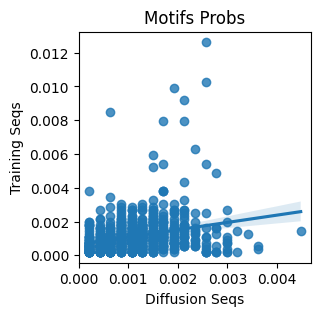

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        2       12        0.000426       0.002164
1          MA0523.1_TCF7L2        7        5        0.001493       0.000902
2           MA0662.1_MIXL1        1        1        0.000213       0.000180
3          MA1601.1_ZNF75D       10       10        0.002132       0.001803
4           MA0840.1_Creb5        4        7        0.000853       0.001262
..                     ...      ...      ...             ...            ...
868          MA0780.1_PAX3        4        2        0.000853       0.000361
869         MA0883.1_Dmbx1        2        6        0.000426       0.001082
870  MA1539.1_NR2F6(var.3)        5        6        0.001066       0.001082
871           MA0842.2_NRL        6        4        0.001279       0.000721
872          MA0798.2_RFX3        1        1        0.000213       0.000180

[873 rows x 5 columns]

1 14 0.351548973531966
15


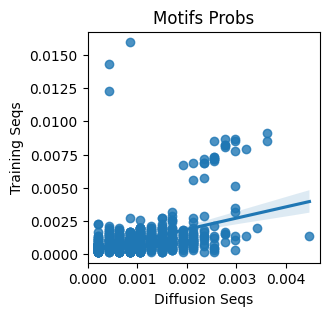

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        2        7        0.000426       0.001063
1          MA0523.1_TCF7L2        7        4        0.001491       0.000608
2           MA0662.1_MIXL1        1        2        0.000213       0.000304
3          MA1601.1_ZNF75D       10        9        0.002130       0.001367
4           MA0840.1_Creb5        4        5        0.000852       0.000760
..                     ...      ...      ...             ...            ...
873          MA0780.1_PAX3        4        1        0.000852       0.000152
874         MA0883.1_Dmbx1        2       10        0.000426       0.001519
875  MA1539.1_NR2F6(var.3)        5        7        0.001065       0.001063
876           MA0842.2_NRL        6        3        0.001278       0.000456
877          MA0798.2_RFX3        1        5        0.000213       0.000760

[878 rows x 5 columns]

1 15 0.3253220473267183
2


/tmp/ipykernel_144277/12519165.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n_a in tqdm_notebook(range(number_of_samples)): # generating 20*10 sequences


  0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



scanning: 100%|███████████████████████| 500/500 [00:08<00:00, 62.21 sequences/s]


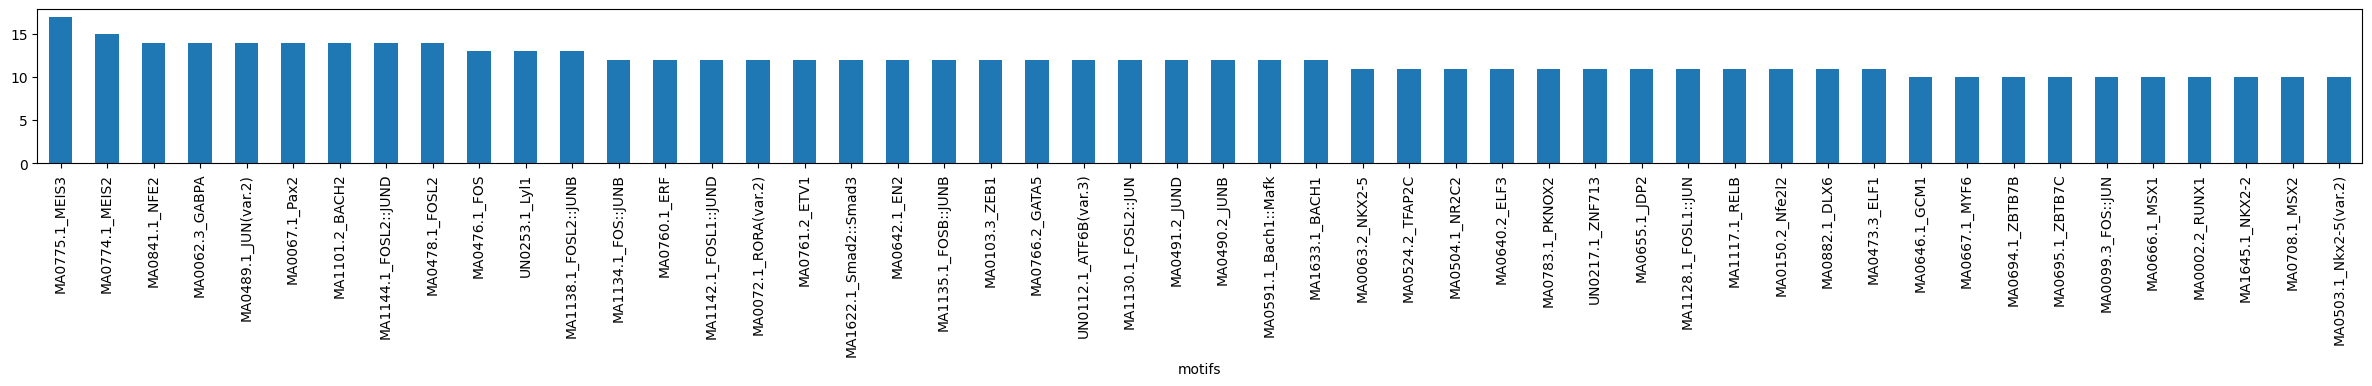

0


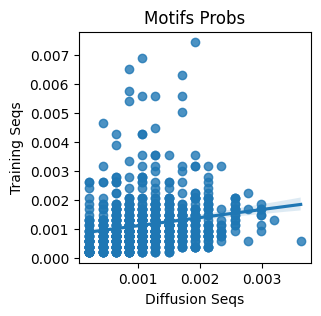

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        4        9        0.000852       0.001677
1          MA0523.1_TCF7L2        6        5        0.001278       0.000932
2           MA0662.1_MIXL1        1        7        0.000213       0.001305
3          MA1601.1_ZNF75D        9        7        0.001918       0.001305
4           MA0840.1_Creb5        4        7        0.000852       0.001305
..                     ...      ...      ...             ...            ...
868          MA0780.1_PAX3        2        7        0.000426       0.001305
869         MA0883.1_Dmbx1        4        1        0.000852       0.000186
870  MA1539.1_NR2F6(var.3)        4        5        0.000852       0.000932
871           MA0842.2_NRL        2        7        0.000426       0.001305
872          MA0798.2_RFX3        4        5        0.000852       0.000932

[873 rows x 5 columns]

2 0 0.2701203482120572
1


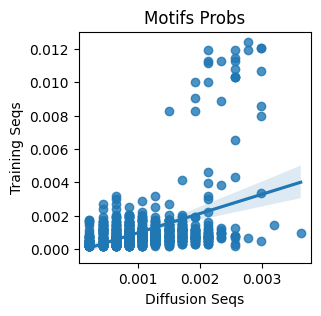

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        4        4        0.000852       0.000636
1          MA0523.1_TCF7L2        6        2        0.001277       0.000318
2           MA0662.1_MIXL1        1        3        0.000213       0.000477
3          MA1601.1_ZNF75D        9        8        0.001916       0.001272
4           MA0840.1_Creb5        4        9        0.000852       0.001432
..                     ...      ...      ...             ...            ...
872          MA0780.1_PAX3        2        1        0.000426       0.000159
873         MA0883.1_Dmbx1        4        9        0.000852       0.001432
874  MA1539.1_NR2F6(var.3)        4        8        0.000852       0.001272
875           MA0842.2_NRL        2        9        0.000426       0.001432
876          MA0798.2_RFX3        4        6        0.000852       0.000954

[877 rows x 5 columns]

2 1 0.36891744297748363
2


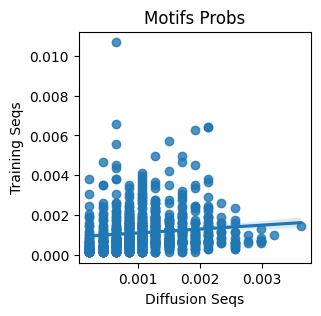

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        4       18        0.000852       0.002632
1          MA0523.1_TCF7L2        6       12        0.001277       0.001755
2           MA0662.1_MIXL1        1        4        0.000213       0.000585
3          MA1601.1_ZNF75D        9        6        0.001916       0.000877
4           MA0840.1_Creb5        4        3        0.000852       0.000439
..                     ...      ...      ...             ...            ...
872          MA0780.1_PAX3        2        2        0.000426       0.000292
873         MA0883.1_Dmbx1        4        9        0.000852       0.001316
874  MA1539.1_NR2F6(var.3)        4        9        0.000852       0.001316
875           MA0842.2_NRL        2        8        0.000426       0.001170
876          MA0798.2_RFX3        4       11        0.000852       0.001608

[877 rows x 5 columns]

2 2 0.35934103747825147
3


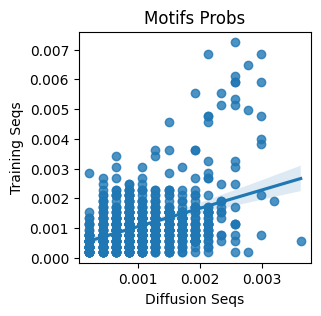

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        4        2        0.000852       0.000381
1          MA0523.1_TCF7L2        6       10        0.001278       0.001907
2           MA0662.1_MIXL1        1        2        0.000213       0.000381
3          MA1601.1_ZNF75D        9       10        0.001917       0.001907
4           MA0840.1_Creb5        4        6        0.000852       0.001144
..                     ...      ...      ...             ...            ...
871          MA0780.1_PAX3        2        1        0.000426       0.000191
872         MA0883.1_Dmbx1        4        5        0.000852       0.000953
873  MA1539.1_NR2F6(var.3)        4        3        0.000852       0.000572
874           MA0842.2_NRL        2        8        0.000426       0.001526
875          MA0798.2_RFX3        4        8        0.000852       0.001526

[876 rows x 5 columns]

2 3 0.2528659287889328
4


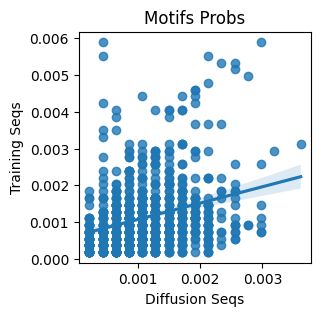

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        4        3        0.000851       0.000552
1          MA0523.1_TCF7L2        6       16        0.001277       0.002944
2           MA0662.1_MIXL1        1        1        0.000213       0.000184
3          MA1601.1_ZNF75D        9        7        0.001916       0.001288
4           MA0840.1_Creb5        4        6        0.000851       0.001104
..                     ...      ...      ...             ...            ...
873          MA0780.1_PAX3        2        2        0.000426       0.000368
874         MA0883.1_Dmbx1        4        1        0.000851       0.000184
875  MA1539.1_NR2F6(var.3)        4        6        0.000851       0.001104
876           MA0842.2_NRL        2        3        0.000426       0.000552
877          MA0798.2_RFX3        4        7        0.000851       0.001288

[878 rows x 5 columns]

2 4 0.30593024903421495
5


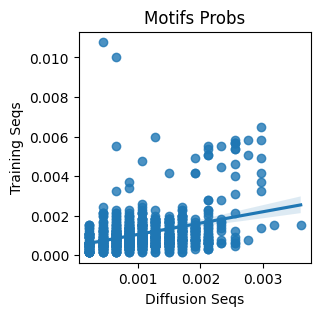

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        4        7        0.000851       0.001077
1          MA0523.1_TCF7L2        6       10        0.001276       0.001539
2           MA0662.1_MIXL1        1        4        0.000213       0.000615
3          MA1601.1_ZNF75D        9        6        0.001914       0.000923
4           MA0840.1_Creb5        4       12        0.000851       0.001846
..                     ...      ...      ...             ...            ...
878          MA0780.1_PAX3        2        6        0.000425       0.000923
879         MA0883.1_Dmbx1        4        8        0.000851       0.001231
880  MA1539.1_NR2F6(var.3)        4        7        0.000851       0.001077
881           MA0842.2_NRL        2        7        0.000425       0.001077
882          MA0798.2_RFX3        4        5        0.000851       0.000769

[883 rows x 5 columns]

2 5 0.2580729372133153
6


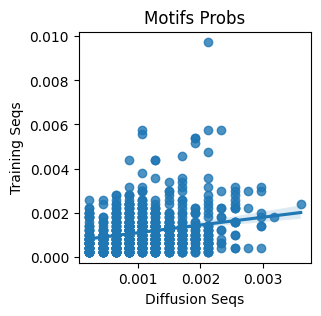

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        4        4        0.000851       0.000795
1          MA0523.1_TCF7L2        6        3        0.001276       0.000596
2           MA0662.1_MIXL1        1        3        0.000213       0.000596
3          MA1601.1_ZNF75D        9        8        0.001914       0.001589
4           MA0840.1_Creb5        4        9        0.000851       0.001788
..                     ...      ...      ...             ...            ...
878          MA0780.1_PAX3        2        1        0.000425       0.000199
879         MA0883.1_Dmbx1        4        3        0.000851       0.000596
880  MA1539.1_NR2F6(var.3)        4       10        0.000851       0.001986
881           MA0842.2_NRL        2        4        0.000425       0.000795
882          MA0798.2_RFX3        4        7        0.000851       0.001391

[883 rows x 5 columns]

2 6 0.33001342968252684
7


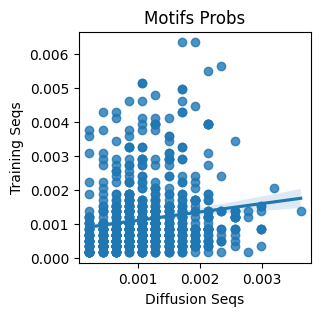

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        4        6        0.000852       0.001028
1          MA0523.1_TCF7L2        6       13        0.001278       0.002228
2           MA0662.1_MIXL1        1       22        0.000213       0.003770
3          MA1601.1_ZNF75D        9        4        0.001917       0.000686
4           MA0840.1_Creb5        4        5        0.000852       0.000857
..                     ...      ...      ...             ...            ...
869          MA0780.1_PAX3        2       12        0.000426       0.002057
870         MA0883.1_Dmbx1        4        5        0.000852       0.000857
871  MA1539.1_NR2F6(var.3)        4        2        0.000852       0.000343
872           MA0842.2_NRL        2       13        0.000426       0.002228
873          MA0798.2_RFX3        4       19        0.000852       0.003256

[874 rows x 5 columns]

2 7 0.3574464680047278
8


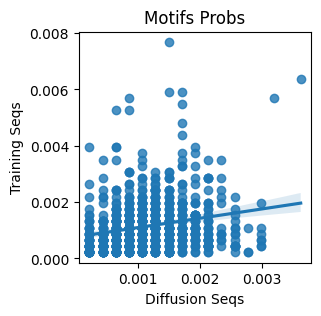

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        4        8        0.000852       0.001754
1          MA0523.1_TCF7L2        6        3        0.001278       0.000658
2           MA0662.1_MIXL1        1        2        0.000213       0.000439
3          MA1601.1_ZNF75D        9        3        0.001917       0.000658
4           MA0840.1_Creb5        4        3        0.000852       0.000658
..                     ...      ...      ...             ...            ...
870          MA0780.1_PAX3        2        3        0.000426       0.000658
871         MA0883.1_Dmbx1        4        2        0.000852       0.000439
872  MA1539.1_NR2F6(var.3)        4        9        0.000852       0.001974
873           MA0842.2_NRL        2        6        0.000426       0.001316
874          MA0798.2_RFX3        4        6        0.000852       0.001316

[875 rows x 5 columns]

2 8 0.3268793175619883
9


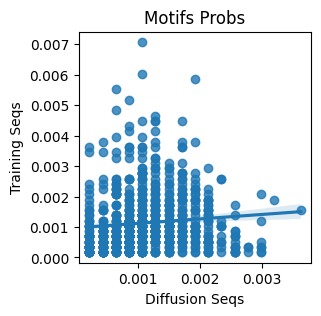

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        4       11        0.000852       0.001896
1          MA0523.1_TCF7L2        6        7        0.001277       0.001206
2           MA0662.1_MIXL1        1        9        0.000213       0.001551
3          MA1601.1_ZNF75D        9        6        0.001916       0.001034
4           MA0840.1_Creb5        4        2        0.000852       0.000345
..                     ...      ...      ...             ...            ...
872          MA0780.1_PAX3        2        3        0.000426       0.000517
873         MA0883.1_Dmbx1        4        6        0.000852       0.001034
874  MA1539.1_NR2F6(var.3)        4       15        0.000852       0.002585
875           MA0842.2_NRL        2        4        0.000426       0.000689
876          MA0798.2_RFX3        4        7        0.000852       0.001206

[877 rows x 5 columns]

2 9 0.4019819363880317
10


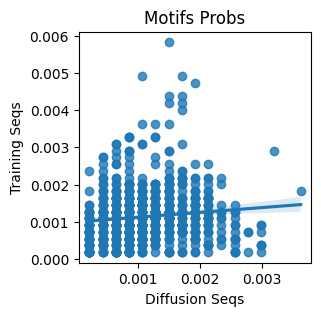

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        4        7        0.000852       0.001274
1          MA0523.1_TCF7L2        6        9        0.001278       0.001638
2           MA0662.1_MIXL1        1        4        0.000213       0.000728
3          MA1601.1_ZNF75D        9        6        0.001917       0.001092
4           MA0840.1_Creb5        4        5        0.000852       0.000910
..                     ...      ...      ...             ...            ...
871          MA0780.1_PAX3        2        6        0.000426       0.001092
872         MA0883.1_Dmbx1        4        5        0.000852       0.000910
873  MA1539.1_NR2F6(var.3)        4        4        0.000852       0.000728
874           MA0842.2_NRL        2       13        0.000426       0.002365
875          MA0798.2_RFX3        4        7        0.000852       0.001274

[876 rows x 5 columns]

2 10 0.3081840349355487
11


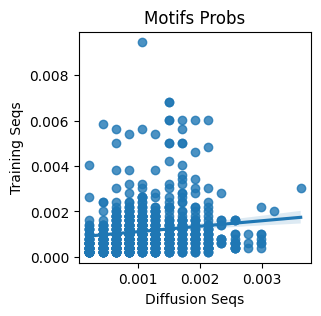

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        4        4        0.000852       0.000805
1          MA0523.1_TCF7L2        6        8        0.001277       0.001609
2           MA0662.1_MIXL1        1        1        0.000213       0.000201
3          MA1601.1_ZNF75D        9        5        0.001916       0.001006
4           MA0840.1_Creb5        4        9        0.000852       0.001811
..                     ...      ...      ...             ...            ...
872          MA0780.1_PAX3        2        4        0.000426       0.000805
873         MA0883.1_Dmbx1        4        7        0.000852       0.001408
874  MA1539.1_NR2F6(var.3)        4        9        0.000852       0.001811
875           MA0842.2_NRL        2        7        0.000426       0.001408
876          MA0798.2_RFX3        4        9        0.000852       0.001811

[877 rows x 5 columns]

2 11 0.3547789825935433
12


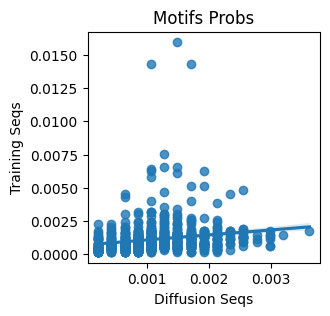

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        4       10        0.000851       0.001611
1          MA0523.1_TCF7L2        6       14        0.001277       0.002255
2           MA0662.1_MIXL1        1        3        0.000213       0.000483
3          MA1601.1_ZNF75D        9        5        0.001915       0.000805
4           MA0840.1_Creb5        4        7        0.000851       0.001127
..                     ...      ...      ...             ...            ...
874          MA0780.1_PAX3        2        5        0.000426       0.000805
875         MA0883.1_Dmbx1        4        3        0.000851       0.000483
876  MA1539.1_NR2F6(var.3)        4       20        0.000851       0.003221
877           MA0842.2_NRL        2        4        0.000426       0.000644
878          MA0798.2_RFX3        4        8        0.000851       0.001288

[879 rows x 5 columns]

2 12 0.2928024838041883
13


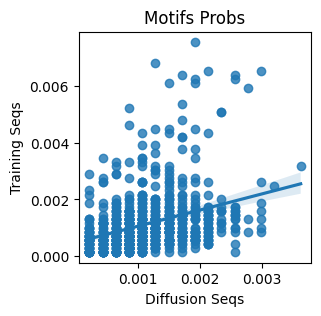

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        4        7        0.000852       0.001013
1          MA0523.1_TCF7L2        6        4        0.001278       0.000579
2           MA0662.1_MIXL1        1        4        0.000213       0.000579
3          MA1601.1_ZNF75D        9       11        0.001917       0.001592
4           MA0840.1_Creb5        4        8        0.000852       0.001158
..                     ...      ...      ...             ...            ...
870          MA0780.1_PAX3        2        2        0.000426       0.000289
871         MA0883.1_Dmbx1        4        2        0.000852       0.000289
872  MA1539.1_NR2F6(var.3)        4        8        0.000852       0.001158
873           MA0842.2_NRL        2        6        0.000426       0.000868
874          MA0798.2_RFX3        4       11        0.000852       0.001592

[875 rows x 5 columns]

2 13 0.2802021430512984
14


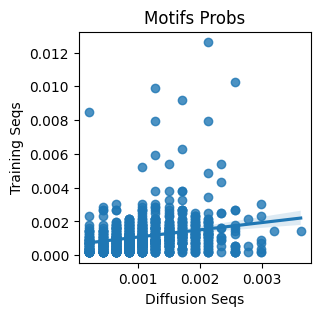

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        4       12        0.000852       0.002163
1          MA0523.1_TCF7L2        6        5        0.001278       0.000901
2           MA0662.1_MIXL1        1        1        0.000213       0.000180
3          MA1601.1_ZNF75D        9       10        0.001917       0.001802
4           MA0840.1_Creb5        4        7        0.000852       0.001261
..                     ...      ...      ...             ...            ...
871          MA0780.1_PAX3        2        2        0.000426       0.000360
872         MA0883.1_Dmbx1        4        6        0.000852       0.001081
873  MA1539.1_NR2F6(var.3)        4        6        0.000852       0.001081
874           MA0842.2_NRL        2        4        0.000426       0.000721
875          MA0798.2_RFX3        4        1        0.000852       0.000180

[876 rows x 5 columns]

2 14 0.34387139725936156
15


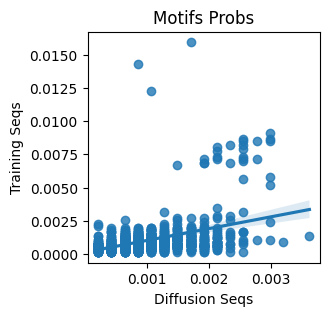

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0          MA1548.1_PLAGL2        4        7        0.000851       0.001063
1          MA0523.1_TCF7L2        6        4        0.001277       0.000607
2           MA0662.1_MIXL1        1        2        0.000213       0.000304
3          MA1601.1_ZNF75D        9        9        0.001915       0.001367
4           MA0840.1_Creb5        4        5        0.000851       0.000759
..                     ...      ...      ...             ...            ...
875          MA0780.1_PAX3        2        1        0.000426       0.000152
876         MA0883.1_Dmbx1        4       10        0.000851       0.001519
877  MA1539.1_NR2F6(var.3)        4        7        0.000851       0.001063
878           MA0842.2_NRL        2        3        0.000426       0.000456
879          MA0798.2_RFX3        4        5        0.000851       0.000759

[880 rows x 5 columns]

2 15 0.32593347308043563
3


/tmp/ipykernel_144277/12519165.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n_a in tqdm_notebook(range(number_of_samples)): # generating 20*10 sequences


  0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [84]:
# new block
# testing the kl all x all components
final_comp_kl = []
for r in range(0, 16):
    print(r), 'component'
    comp_array = []
    synt_df_cond = sampling_to_metric(50, 0)
    for k, v in final_comp_values.items():
        print(k)
        kl_out = compare_motif_list(synt_df_cond, v)
        print(r, k, kl_out)
        comp_array.append(kl_out)
    final_comp_kl.append(comp_array)

In [78]:
from scipy.stats import zscore

<AxesSubplot: >

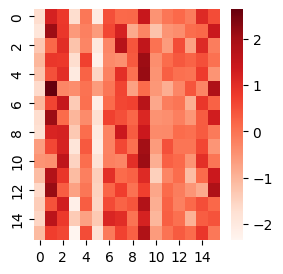

In [81]:
# not a nice result (Nice diffusion results (low kl), but not a nice conditioning results (the synhetic conditional component sequences should be correlated with their respective component training sequences))
sns.heatmap(zscore(pd.DataFrame(final_comp_kl), 1), cmap='Reds')

## METRIC [1,-1,-1,-1] X SORT(VMAX, VMIN, VMIN, VMIN) IN all sequences

# Create an diffusion animation

In [ ]:
# sample sequences
samples = sample(model, image_size=image_size, batch_size=10, channels=1)

random_index = 0
!rm image_temp
!mkdir image_temp
fig = plt.figure()
ims = []
for i in range(timesteps):
    plt.rcParams["figure.figsize"] = (20, 1)
    pd_seq = pd.DataFrame(samples[i][random_index].reshape(4, 200))
    pd_seq.index = nucleotides

    sns.heatmap(pd_seq, linewidth=1, cmap='bwr', center=0)
    plt.savefig(f'image_temp/{i}_temp.jpg')
    plt.show()
    plt.clf()

In [ ]:
def make_gif():
    images_to_sort = !ls image_temp -lt
    # print (images_to_sort)
    images_reverse = [x.split(' ')[-1] for x in images_to_sort][1:]
    images_reverse = images_reverse[::-1]

    frames = [Image.open(f'image_temp/{image}') for image in images_reverse]
    # print (len(frames))
    frame_one = frames[0]
    frame_one.save("diff_first.gif", format="GIF", append_images=frames, save_all=True, duration=30, loop=0)

In [ ]:
make_gif()